# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Подготовка к работе

In [1]:
# функция для кнопки скрытия кода
from IPython.display import (
    display,
    HTML
)

def create_toggle_code_button(button_text="Переключить видимость"):
    toggle_code_str = f'''
    <form action="javascript:code_toggle()">
        <input type="submit" id="toggleButton" value="{button_text}">
    </form>
    '''

    toggle_code_prepare_str = '''
    <script>
    function code_toggle() {
        $('div.cell.code_cell.rendered.selected div.input').toggle();
    }
    </script>
    '''

    display(HTML(toggle_code_prepare_str + toggle_code_str))

create_toggle_code_button("Функция спойлера")

### Библиотеки

In [2]:
%%time
# здесь будем ставить все, чего нам не хватает
!pip install missingno -q
!pip install phik -q
!pip install --upgrade scikit-learn -q
!pip install tdqm -q
!pip install imbalanced-learn -q
!pip install pyflakes flake8 -q

create_toggle_code_button("Установка и обновление библиотек")

ERROR: Could not find a version that satisfies the requirement pyflakes (from versions: none)
ERROR: No matching distribution found for pyflakes


CPU times: total: 15.6 ms
Wall time: 55.6 s


### Импорты

In [3]:
# а здесь импортировать все для работы
import warnings

import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno

from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import (
    LogisticRegression,
    LinearRegression,
    Ridge
)

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    make_scorer,
    mean_squared_error,
    r2_score,
    mean_absolute_error
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.exceptions import ConvergenceWarning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import (
    Pipeline,
    FeatureUnion
)
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder,
    PolynomialFeatures,
    FunctionTransformer
)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from phik import phik_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from plotly.subplots import make_subplots
from tqdm import tqdm
from joblib import parallel_backend
from imblearn.over_sampling import SMOTE
from scipy import stats
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression

create_toggle_code_button("Импорты")

### Функции

In [4]:
# 1. Настройка окружения
# sns.set()  # Устанавливает стиль визуализации для графиков Seaborn
# pd.set_option()  # Настраивает формат отображения чисел в DataFrame
# warnings.simplefilter()  # Игнорирует предупреждения определенного типа

# 2. Функции для предварительной обработки данных
# missing_data(data) - Оценивает и отображает количество пропущенных значений в DataFrame
# drop_duplicated(data) - Проверяет и удаляет дубликаты в DataFrame
# check_data(data) - Выполняет проверку и очистку данных, включая пропуски и дубликаты
# process_spaces(s) - Удаляет лишние пробелы в строке
# replace_spaces(s) - Заменяет пробелы на нижние подчеркивания в строке

# 3. Анализ данных
# check_unique_cat(data) - Проверяет уникальные значения в категориальных столбцах
# check_numeric_columns(data) - Возвращает список количественных столбцов в DataFrame
# get_ohe_columns(data) - Возвращает бинарные категориальные столбцы (с 2 уникальными значениями)
# get_ord_columns(data) - Возвращает категориальные столбцы (с более чем 2 уникальными значениями)
# get_num_columns(data) - Возвращает количественные столбцы

# 4. Визуализация данных
# plot_numerical_columns(data) - Строит боксплоты для количественных столбцов
# plot_numerical_columns_hist(data, target_column) - Строит гистограммы для количественных столбцов
# plot_combined(data, col=None, target=None, col_type=None, legend_loc='best') - Строит комбинированные графики (гистограммы и боксплоты) для количественных столбцов
# plot_density_heatmap(data, x, y) - Строит тепловую карту плотности для двух переменных
# plot_scatter_with_categories(data) - Строит диаграммы рассеяния с разбивкой по категориальным данным
# plot_categorical_columns(data, col, target) - Визуализирует категориальные данные с возможностью группировки по целевому столбцу
# plot_scatter_with_numerical(data, target_column) - Строит диаграммы рассеяния с регрессионной линией для количественных признаков

# 5. Статистический анализ
# get_vif(data, drop_col, target_col) - Вычисляет VIF для признаков в данных
# smape(y_true, y_pred) - Вычисляет SMAPE (симметричное среднее абсолютное процентное отклонение)
# get_r2(model_lr, X_test, y_test) - Вычисляет R² для модели линейной регрессии
# get_mae(model, X, y_true) - Вычисляет MAE (среднюю абсолютную ошибку)
# get_mse(model, X, y_true) - Вычисляет MSE (среднюю квадратичную ошибку)
# get_rmse(model, X, y_true) - Вычисляет RMSE (корень из средней квадратичной ошибки)

# 6. Объединение данных
# merge_base(bases, index, merge_type) - Объединяет список DataFrame по заданному индексу и типу объединения

# 7. Дополнительные функции
# format_display(text) - Форматирует текст для красивого отображения в Jupyter Notebook
# analyze_data(dataframes, drop_columns) - Анализирует данные и строит графики распределения для общих числовых столбцов
# calculate_phik_correlations(dataframes, target_column, drop_columns) - Вычисляет корреляцию признаков с целевым значением с использованием phik для нескольких баз данных
# get_model_lin_reg(X_test, y_test) - Обучает модель линейной регрессии и выводит случайные предсказания
# get_rest(model_lr, X_test, y_test) - Анализирует остатки модели линейной регрессии и строит графики

create_toggle_code_button("Описание функций")

In [5]:
# это даст нам красивые выводы
sns.set()
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.simplefilter(action='ignore', category=FutureWarning)

# форматирования текста
def format_display(text):
    return HTML(f"<span style='font-size: 1.5em; font-weight: bold; font-style: italic;'>{text}</span>")

# сделаем функцию оценки пропусков в датасетах
def missing_data(data):
    missing_data = data.isna().sum()
    missing_data = missing_data[missing_data > 0]
    display(missing_data)
    
# функция для обработки пробелов
def process_spaces(s):
    if isinstance(s, str):
        s = s.strip()
        s = ' '.join(s.split())
    return s

# замена пробелов на нижнее подчеркинвание в названии столбцов
def replace_spaces(s):
    if isinstance(s, str):
        s = s.strip()
        s = '_'.join(s.split())
    return s

def drop_duplicated(data):
    # проверка дубликатов
    display(format_display("Проверим дубликаты и удалим, если есть"))
    num_duplicates = data.duplicated().sum()
    display(num_duplicates)
    
    if num_duplicates > 0:
        display("Удаляем")
        data = data.drop_duplicates(keep='first').reset_index(drop=True)  # обновляем DataFrame
    else:
        display("Дубликаты отсутствуют")
    return data

def check_data(data):
    # приведем все к нижнему регистру
    data.columns = data.columns.str.lower()
    
    # удалим лишние пробелы в строках
    data = data.applymap(process_spaces)

    # и в названии столбцов
    data.columns = [replace_spaces(col) for col in data.columns]
    
    # общая информация 
    display(format_display("Общая информация базы данных"))
    display(data.info())
    
    # 5 строк
    display(format_display("5 случайных строк"))
    display(data.sample(5))
    
    # пропуски
    display(format_display("Число пропусков в базе данных"))
    display(missing_data(data))

    # проверка на наличие пропусков
    if data.isnull().sum().sum() > 0:
        display(format_display("Визуализация пропусков"))
        msno.bar(data)
        plt.show()
        
    # средние характеристики
    display(format_display("Характеристики базы данных"))
    display(data.describe().T)
    
    data = drop_duplicated(data)
    
    return data  # возвращаем измененные данные

def check_unique_cat(data):
    text_columns = data.select_dtypes(include=['object'])
    
    if text_columns.empty:
        display("В DataFrame нет столбцов с данными типа 'object'.")
        return
    
    unique_values = {col: text_columns[col].unique() for col in text_columns.columns}
    for col, values in unique_values.items():
        display(f"Уникальные значения в столбце '{col}': {values}")
        
def check_numeric_columns(data):
    numeric_columns = data.select_dtypes(include=['int64', 'float64'])
    
    if numeric_columns.empty:
        return []
    else:
        return numeric_columns.columns.tolist()
    
# боксплот - только столбцы типа int и float
def plot_numerical_columns(data):
    numerical_columns = data.select_dtypes(include=['int', 'float']).columns.tolist()
    
    n = len(numerical_columns)
    ncols = 3
    nrows = (n + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5 * nrows))
    axs = axs.flatten()

    for i, col in enumerate(numerical_columns):
        axs[i].boxplot(data[col].dropna())
        axs[i].set_title(col)
        axs[i].set_ylabel('Значения')
        axs[i].set_xticklabels([''])

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()
    
def plot_numerical_columns_hist(data, target_column=None):
    numerical_columns = data.select_dtypes(include=['int', 'float']).columns.tolist()
    num_cols = len(numerical_columns)
    
    ncols = 2
    nrows = int(np.ceil(num_cols / ncols))

    f, axes = plt.subplots(nrows, ncols, figsize=(16, nrows * 4))
    axes = axes.flatten()

    for i, col in enumerate(numerical_columns):
        # Гистограмма
        axes[i].set_title(f'Распределение признака {col}', fontsize=16)
        axes[i].set_ylabel('Количество', fontsize=14)

        if target_column and target_column in data.columns:
            sns.histplot(data=data, x=col, bins=20, kde=True, ax=axes[i], hue=target_column, multiple="stack")
        else:
            sns.histplot(data=data, x=col, bins=20, kde=True, ax=axes[i])

    for j in range(i + 1, nrows * ncols):
        f.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def plot_combined(data, col=None, target=None, col_type=None, legend_loc='best'):
    """
    Строит графики для числовых столбцов в DataFrame, автоматически определяя их типы (дискретные или непрерывные).

    :param data: DataFrame, содержащий данные для визуализации.
    :param col: Список столбцов для построения графиков. Если None, будут использованы все числовые столбцы.
    :param target: Столбец, по которому будет производиться разделение (для hue в графиках).
    :param col_type: Словарь, определяющий типы столбцов ('col' для непрерывных и 'dis' для дискретных).
                     Если None, типы будут определены автоматически.
    :param legend_loc: Положение легенды для графиков (по умолчанию 'best').
    :return: None. Графики отображаются с помощью plt.show().
    """
    
    # Определяем числовые столбцы
    if col is None:
        numerical_columns = data.select_dtypes(include=['int', 'float']).columns.tolist()
    else:
        numerical_columns = col

    # Если col_type не указан, определяем типы автоматически
    if col_type is None:
        col_type = {}
        for col in numerical_columns:
            unique_count = data[col].nunique()
            if unique_count > 20:
                col_type[col] = 'col'  # Непрерывные данные
            else:
                col_type[col] = 'dis'  # Дискретные данные

    total_plots = len(numerical_columns) * 2
    ncols = 2
    nrows = (total_plots + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows))
    axs = axs.flatten()

    index = 0

    for col in numerical_columns:
        # Определяем тип графика
        plot_type = col_type.get(col)
        if plot_type is None:
            raise ValueError(f"Тип для столбца '{col}' не указан в col_type.")

        # Гистограмма или countplot
        if index < len(axs):
            if plot_type == 'col':
                if target is not None:
                    sns.histplot(data, x=col, hue=target, bins=20, kde=True, ax=axs[index])
                    handles, labels = axs[index].get_legend_handles_labels()
                    if handles:
                        axs[index].legend(title=target, loc=legend_loc)
                else:
                    sns.histplot(data[col].dropna(), bins=20, kde=True, ax=axs[index])
                axs[index].set_title(f'Гистограмма: {col}')
                axs[index].tick_params(axis='x', rotation=90)  # Вертикальные метки

            elif plot_type == 'dis':
                if target is not None:
                    sns.countplot(data=data, x=col, hue=target, ax=axs[index])
                    handles, labels = axs[index].get_legend_handles_labels()
                    if handles:
                        axs[index].legend(title=target, loc=legend_loc)
                else:
                    sns.countplot(data=data, x=col, ax=axs[index])
                axs[index].set_title(f'Countplot: {col}')
                axs[index].tick_params(axis='x', rotation=90)  # Вертикальные метки

            index += 1

        # Боксплот
        if index < len(axs):
            sns.boxplot(x=data[col], ax=axs[index])
            axs[index].set_title(f'Боксплот: {col}')
            index += 1

    # Отключаем оставшиеся оси
    for j in range(index, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

    
def get_ohe_columns(data):
    # выбор бинарных признаков (категориальные с 2 уникальными значениями)
    return data.select_dtypes(include=['object']).nunique()[data.select_dtypes(include=['object']).nunique() == 2].index.tolist()

def get_ord_columns(data):
    # выбор категориальных признаков (с более чем 2 уникальными значениями)
    return data.select_dtypes(include=['object']).nunique()[data.select_dtypes(include=['object']).nunique() > 2].index.tolist()

def get_num_columns(data):
    # используем уже созданную функцию для получения количественных признаков
    return check_numeric_columns(data)

def histogram(data, col, target):
    plt.figure(figsize=(8,6))
    plot = sns.histplot(data, bins=20, kde=True, hue=target, x=col)
    plot.set_title(f'Рапределение по {col}', fontsize=16)
    plot.set_ylabel('Количество', fontsize=14)
    
def plot_density_heatmap(data, x, y):
    fig = px.density_heatmap(data, x=x, y=y, nbinsx=50, nbinsy=50, color_continuous_scale='Greens')
    fig.update_layout(title=f'Зависимость {x} от {y}',
                      xaxis_title=x,
                      yaxis_title=y,
                      width=600,
                      height=500)
    fig.show()
    
class ReplaceEmptyWithNaN(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.where((X == '') | (X.isnull()), np.nan, X)

    def get_feature_names_out(self, input_features=None):
        return input_features
    
def merge_base(bases, index, merge_type):
    """
    Объединяет список таблиц по заданному индексу.

    :param bases: Список таблиц (DataFrame), которые нужно объединить.
    :param index: Имя столбца, по которому будет происходить объединение.
    :param merge_type: Тип объединения ('inner', 'outer', 'left', 'right').
    :return: Объединённая таблица.
    """
    merged_df = bases[0]
    for base in bases[1:]:
        merged_df = pd.merge(merged_df, base, on=index, how=merge_type)

    return merged_df

def plot_scatter_with_categories(data):
    """
    Функция для построения диаграмм рассеяния с разбивкой по категориальным данным.
    
    :param data: DataFrame с данными.
    """
    categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()
    
    for column in categorical_columns:
        plt.figure(figsize=(15, 10))
        sns.scatterplot(data=data, x='quit', y='satisfaction_predictions', hue=column, alpha=0.7)
        plt.xlabel('Вероятность таргета')
        plt.ylabel('Признак')
        plt.title(f'Зависимость вероятности от признака {column}')
        plt.legend(title=column)
        plt.show()
        
def plot_scatter_with_numerical(data, target_column):
    """
    Функция для построения диаграммы рассеяния с регрессионной линией.
    
    :param data: DataFrame с данными.
    :param target_column: Название столбца с целевым признаком.
    """
    numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    if target_column in numerical_columns:
        numerical_columns.remove(target_column)

    for column in numerical_columns:
        plt.figure(figsize=(15, 6))

        # Диаграмма рассеяния с регрессионной линией
        plt.subplot(1, 1, 1)
        sns.regplot(data=data, x=column, y=target_column, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
        plt.title(f'Зависимость {target_column} от {column}')
        plt.xlabel(column)
        plt.ylabel(target_column)

        plt.tight_layout()
        plt.show()
        
def plot_categorical_columns(data, col=None, target=None):
    """
    Функция для визуализации категориальных данных с возможностью группировки по целевому столбцу.
    
    :param data: DataFrame с категориальными данными
    :param col: Название столбца для визуализации (по умолчанию None — визуализируются все категориальные столбцы)
    :param target: Название столбца для группировки данных (по умолчанию None — без группировки)
    :return: None — функция отображает графики
    """
    categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
    
    if col is not None and col in categorical_columns:
        categorical_columns = [col]
    elif col is not None:
        print(f"Столбец '{col}' не найден в данных.")
        return

    n = len(categorical_columns)
    ncols = 2
    nrows = (n * 2 + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6 * nrows))
    axs = axs.flatten()

    index = 0
    colors = plt.cm.tab10.colors

    for col in categorical_columns:
        unique_values = data[col].value_counts().index
        color_map = {value: colors[i] for i, value in enumerate(unique_values)}

        # Визуализация круговой диаграммы
        grouped_data = data[col].value_counts()
        axs[index].pie(grouped_data, labels=grouped_data.index, autopct='%1.1f%%', startangle=90, colors=[color_map[val] for val in grouped_data.index])
        axs[index].set_title(f'{col} (общая)')
        axs[index].set_ylabel('')
        index += 1

        # Визуализация гистограммы
        if target is not None and target in data.columns:
            # Создаем MultiIndex для unstack
            grouped_data = data.groupby([target, col]).size().unstack(fill_value=0)
            grouped_data.plot(kind='bar', ax=axs[index], color=[color_map[val] for val in grouped_data.columns])
        else:
            data[col].value_counts().plot(kind='bar', ax=axs[index], color=[color_map[val] for val in data[col].value_counts().index])

        axs[index].set_title(f'{col} (гистограмма)')
        axs[index].set_ylabel('Частота')
        index += 1

    for j in range(index, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()
    
def get_vif(data, drop_col, target_col):
    """
    Вычисляет VIF для признаков в данных.

    Параметры:
    data: DataFrame с исходными данными.
    drop_col: Название столбца, который нужно исключить.
    target_col: Название целевого столбца, который нужно исключить.

    Возвращает:
    DataFrame с признаками и их VIF.
    """
    X_test = data.drop(columns=[drop_col, target_col])

    le = LabelEncoder()
    for col in X_test.select_dtypes(include=['object']).columns:
        X_test[col] = le.fit_transform(X_test[col])

    X_test = X_test.assign(const=1)

    vif_data = pd.DataFrame()
    vif_data["Признаки"] = X_test.columns
    vif_data["VIF"] = [variance_inflation_factor(X_test.values, i) for i in range(X_test.shape[1])]

    vif_data = vif_data[vif_data["Признаки"] != "const"]

    return vif_data

def smape(y_true, y_pred):
    """
    Вычисляет SMAPE (симметричное среднее абсолютное процентное отклонение).
    
    :param y_true: Фактические значения (numpy array или pandas Series)
    :param y_pred: Предсказанные значения (numpy array или pandas Series)
    :return: Значение SMAPE
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0  # Избегаем деления на ноль
    
    return 100 * np.mean(diff)

def get_r2(model_lr, X_test, y_test):
    r_squared = model_lr.score(X_test, y_test)
    return r_squared

def get_mae(model, X, y_true):
    y_pred = model.predict(X)
    mae = mean_absolute_error(y_true, y_pred)
    return mae

def get_mse(model, X, y_true):
    y_pred = model.predict(X)
    mse = mean_squared_error(y_true, y_pred)
    return mse

def get_rmse(model, X, y_true):
    # получение предсказаний
    y_pred = model.predict(X)
    
    mse = mean_squared_error(y_true, y_pred)
    
    # Расчет RMSE
    rmse = np.sqrt(mse)
    return rmse

def analyze_data(dataframes, drop_columns):
    """
    Анализирует данные, удаляет указанные столбцы и строит графики распределения
    для общих числовых столбцов.

    :param dataframes: Список баз данных (списки pandas DataFrame)
    :param drop_columns: Список столбцов для удаления (список строк)
    """

    cleaned_data = [df.drop(columns=drop_columns, errors='ignore') for df in dataframes]
    
    common_columns = set(cleaned_data[0].select_dtypes(include=['float64', 'int64']).columns)
    for df in cleaned_data[1:]:
        common_columns.intersection_update(df.select_dtypes(include=['float64', 'int64']).columns)

    if not common_columns:
        print("Нет общих числовых столбцов для анализа.")
        return

    common_columns = list(common_columns)

    combined_data = pd.concat(
        [df[common_columns].assign(dataset=f'base_{i+1}') for i, df in enumerate(cleaned_data)],
        keys=[f'base_{i+1}' for i in range(len(cleaned_data))],
        names=['dataset', 'index']
    )

    palette = sns.color_palette("husl", len(cleaned_data))

    for column in common_columns:
        plt.figure(figsize=(10, 6))
        sns.kdeplot(data=combined_data, x=column, hue='dataset', common_norm=False, fill=True, palette=palette)
        plt.title(f'Распределение {column}')
        plt.xlabel(column)
        plt.ylabel('Плотность')
        
        handles, labels = plt.gca().get_legend_handles_labels()
        if handles:
            plt.legend(title='Набор данных', loc='best', labels=[f'Таблица {label}' for label in labels])
        
        plt.show()

    # Пример использования
    # analyze_data([train_data, features_test_data], ['id'])
    
def calculate_phik_correlations(dataframes, target_column, drop_columns=None):
    """
    Вычисляет корреляцию признаков с целевым значением с использованием phik
    для нескольких баз данных и возвращает DataFrame с корреляциями.

    :param dataframes: Список pandas DataFrame с данными
    :param target_column: Название целевого столбца
    :param drop_columns: Список столбцов для исключения из анализа
    :return: DataFrame с корреляциями по базам
    """
    combined_corr = pd.DataFrame()

    for i, df in enumerate(dataframes):
        if drop_columns:
            df = df.drop(columns=drop_columns, errors='ignore')

        phik_corr = df.phik_matrix()

        for feature in phik_corr.index:
            if feature != target_column:
                combined_corr.loc[feature, f'base_{i+1}'] = phik_corr.loc[feature, target_column]

    combined_corr.index.name = 'Feature'
    
    return combined_corr


def get_model_lin_reg(X_test, y_test):
    model_lr = LinearRegression()
    model_lr.fit(X_test, y_test)

    predictions = model_lr.predict(X_test)

    random_indices = np.random.choice(len(y_test), size=2, replace=False)

    display("Проверим как обучилась модель:")
    for index in random_indices:
        display(f"Реальное значение: {y_test.iloc[index]}, Предсказанное значение: {predictions[index]}")

    return model_lr

def get_rest(model_lr, X_test, y_test):
    y_pred = model_lr.predict(X_test)
    residuals = y_test - y_pred

    plt.figure(figsize=(14, 6))
    
    # гистограмма остатков
    plt.subplot(1, 2, 2)
    plt.hist(residuals, bins=30)
    plt.axvline(np.mean(residuals), color='red', linestyle='--', label='Среднее')
    plt.title('Гистограмма остатков')
    plt.xlabel('Остатки')
    plt.ylabel('Частота')
    plt.legend()
    
    # график остатков
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--', label='Среднее')
    plt.title('Анализ остатков')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Остатки')

    plt.tight_layout()
    plt.show()
    
def get_scaler(dataframe_encoded):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(dataframe_encoded)
    return data_scaled

def get_target(data, target):
    X = data.drop(target, axis=1)
    y = data[target]
    return X, y

def visualize_profits(profits_list, region_names):
    plt.figure(figsize=(18, 12))

    for i in range(len(profits_list)):
        plt.subplot(1, len(profits_list), i + 1)
        
        plt.boxplot(profits_list[i], patch_artist=True,
                    boxprops=dict(facecolor='skyblue', color='black'),
                    whiskerprops=dict(color='black'),
                    capprops=dict(color='black'),
                    medianprops=dict(color='red'))

        mean = np.mean(profits_list[i])
        ci_low = np.percentile(profits_list[i], 2.5)
        ci_high = np.percentile(profits_list[i], 97.5)

        plt.errorbar(1, mean, yerr=[[mean - ci_low], [ci_high - mean]], 
                     fmt='o', color='black', capsize=5, label='95% ДИ')

        plt.axhline(y=ci_low, color='red', linestyle='--', label='Нижняя граница ДИ')
        plt.axhline(y=ci_high, color='green', linestyle='--', label='Верхняя граница ДИ')

        plt.text(1.05, ci_low + 20_000_000, f'{ci_low:,.0f}', color='red', fontsize=10, va='center')
        plt.text(1.05, ci_high + 20_000_000, f'{ci_high:,.0f}', color='green', fontsize=10, va='center')

        plt.title(region_names[i])
        plt.ylabel('Прибыль (руб)')
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

    plt.suptitle('Распределение прибыли по регионам с 95% доверительными интервалами', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.legend()
    plt.show()
    
def visualize_profits_on_one(profits_list, region_names):
    plt.figure(figsize=(18, 12))

    box_data = [profits_list[i] for i in range(len(profits_list))]
    
    plt.boxplot(box_data, patch_artist=True,
                boxprops=dict(facecolor='skyblue', color='black'),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                medianprops=dict(color='red'))

    for i in range(len(box_data)):
        mean = np.mean(box_data[i])
        ci_low = np.percentile(box_data[i], 2.5)
        ci_high = np.percentile(box_data[i], 97.5)

        plt.errorbar(i + 1, mean, yerr=[[mean - ci_low], [ci_high - mean]], 
                     fmt='o', color='black', capsize=5, label='95% ДИ' if i == 0 else "")

        plt.axhline(y=ci_low, color='red', linestyle='--', label='Нижняя граница ДИ' if i == 0 else "")
        plt.axhline(y=ci_high, color='green', linestyle='--', label='Верхняя граница ДИ' if i == 0 else "")

        plt.text(i + 1.05, ci_low + 40_000_000, f'{ci_low:,.0f}', color='red', fontsize=15, va='center')
        plt.text(i + 1.05, ci_high + 40_000_000, f'{ci_high:,.0f}', color='green', fontsize=15, va='center')

    plt.xticks(range(1, len(region_names) + 1), region_names)
    plt.ylabel('Прибыль (руб)')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

    plt.suptitle('Распределение прибыли по регионам с 95% доверительными интервалами', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.legend()
    plt.show()
    
create_toggle_code_button("Функции")

### Константы

In [6]:
# зафиксируем константы для последующего обучения
RANDOM_STATE = 20
TEST_SIZE = 0.25

## Загрузка и подготовка данных

### Загрузка данных

In [7]:
# данные по регионам добычи
geo_data_0 = pd.read_csv('geo_data_0.csv')
geo_data_1 = pd.read_csv('geo_data_1.csv')
geo_data_2 = pd.read_csv('geo_data_2.csv')

### Обработка данных

In [8]:
# посмотрим, что у нас в каждом файле имеется
geo_data_0 = check_data(geo_data_0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
96843,PJN9T,2.13,0.31,8.47,111.64
36411,r0wSE,-0.68,0.66,1.23,56.62
57246,BR9D9,1.07,0.18,3.30,24.76
94724,1pySk,1.84,-0.28,1.44,72.95
43135,TreUX,1.63,-0.14,6.55,33.10


Series([], dtype: int64)

None

,count,mean,std,min,25%,50%,75%,max
f0,100000.00,0.50,0.87,-1.41,-0.07,0.50,1.07,2.36
f1,100000.00,0.25,0.50,-0.85,-0.20,0.25,0.70,1.34
f2,100000.00,2.50,3.25,-12.09,0.29,2.52,4.72,16.00
product,100000.00,92.50,44.29,0.00,56.50,91.85,128.56,185.36


0

'Дубликаты отсутствуют'

Проверим отдельно дубликаты по id скважин, т.к. набор данных в признаках синтетический и могло затереться то, что важно.

In [9]:
geo_data_0['id'].nunique()

99990

Да, оказалось 10 дублей. Удалим.

In [10]:
geo_data_0 = geo_data_0.drop_duplicates(subset=['id'])
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99990 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99990 non-null  object 
 1   f0       99990 non-null  float64
 2   f1       99990 non-null  float64
 3   f2       99990 non-null  float64
 4   product  99990 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


In [11]:
geo_data_1 = check_data(geo_data_1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
36357,24vGc,8.45,-7.48,5.01,134.77
36445,9Z9A3,-3.64,-1.46,4.01,110.99
4361,t3NBg,4.30,-3.34,5.01,134.77
54709,xWFIX,13.02,-8.66,3.99,107.81
75497,CLYOB,-8.63,-17.11,1.00,30.13


Series([], dtype: int64)

None

,count,mean,std,min,25%,50%,75%,max
f0,100000.00,1.14,8.97,-31.61,-6.30,1.15,8.62,29.42
f1,100000.00,-4.80,5.12,-26.36,-8.27,-4.81,-1.33,18.73
f2,100000.00,2.49,1.70,-0.02,1.00,2.01,4.00,5.02
product,100000.00,68.83,45.94,0.00,26.95,57.09,107.81,137.95


0

'Дубликаты отсутствуют'

In [12]:
geo_data_1['id'].nunique()

99996

In [13]:
geo_data_1 = geo_data_1.drop_duplicates(subset=['id'])
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


In [14]:
geo_data_2 = check_data(geo_data_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
45996,kP4av,-0.17,-1.10,7.18,144.58
66829,Rocye,1.17,-2.09,5.50,135.81
14539,newqT,2.07,0.26,1.36,137.83
14286,Kyi6o,1.43,-1.22,2.14,62.29
9631,vy6iZ,2.07,-2.16,-0.05,55.30


Series([], dtype: int64)

None

,count,mean,std,min,25%,50%,75%,max
f0,100000.00,0.00,1.73,-8.76,-1.16,0.01,1.16,7.24
f1,100000.00,-0.00,1.73,-7.08,-1.17,-0.01,1.16,7.84
f2,100000.00,2.50,3.47,-11.97,0.13,2.48,4.86,16.74
product,100000.00,95.00,44.75,0.00,59.45,94.93,130.60,190.03


0

'Дубликаты отсутствуют'

In [15]:
geo_data_2['id'].nunique()

99996

In [16]:
geo_data_2 = geo_data_2.drop_duplicates(subset=['id'])
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


Во всех таблицах все данные на месте, пропусков нет, явных отклонений не наблюдается.  
В каждой таблице есть дубликаты по id - их мы удалили и оставили только первые встречные.  
Смущает только один момент - что в каждой таблице есть данные о точках с нулевой добычей.

### Анализ данных

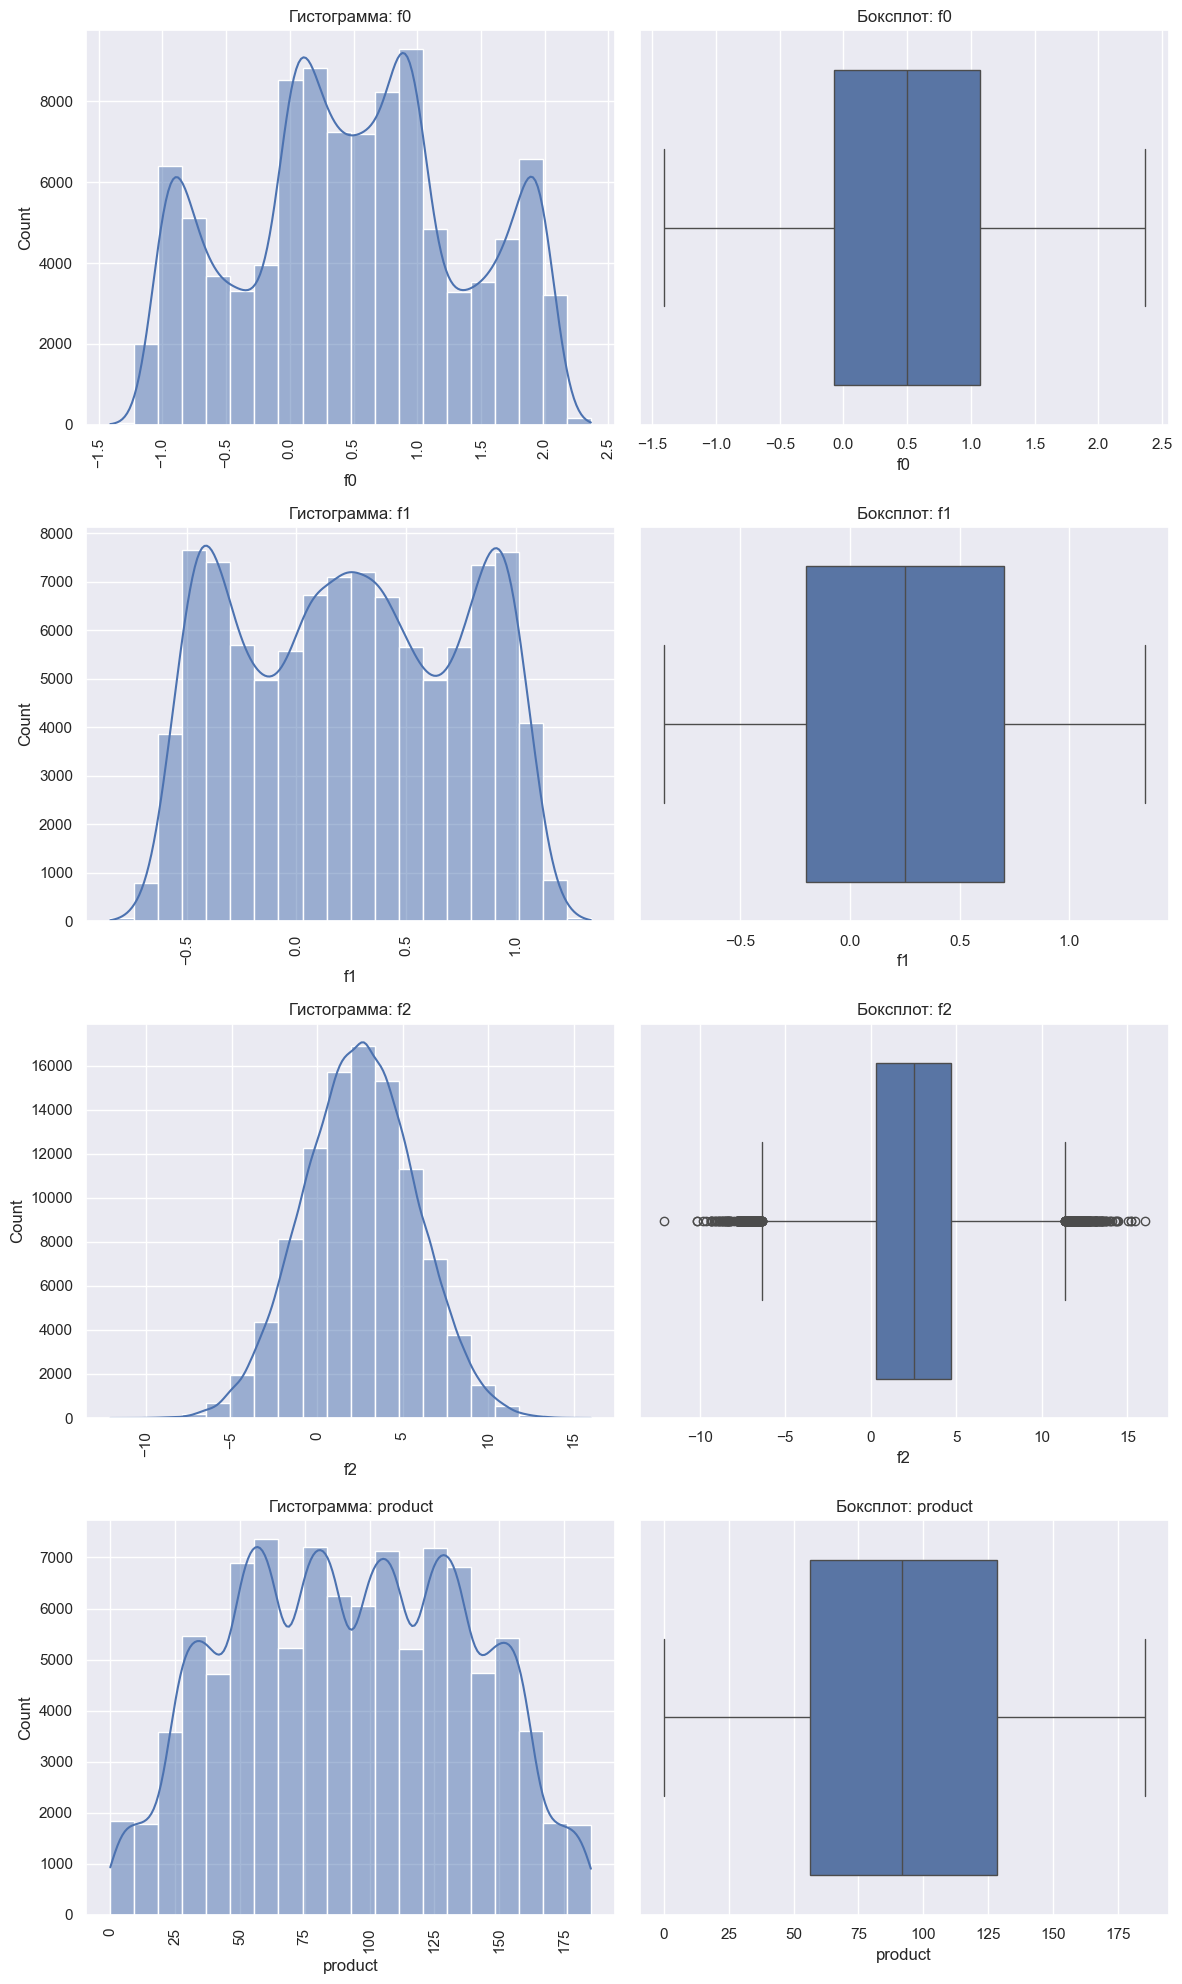

In [17]:
plot_combined(geo_data_0, col=None, target=None, col_type=None, legend_loc='best')

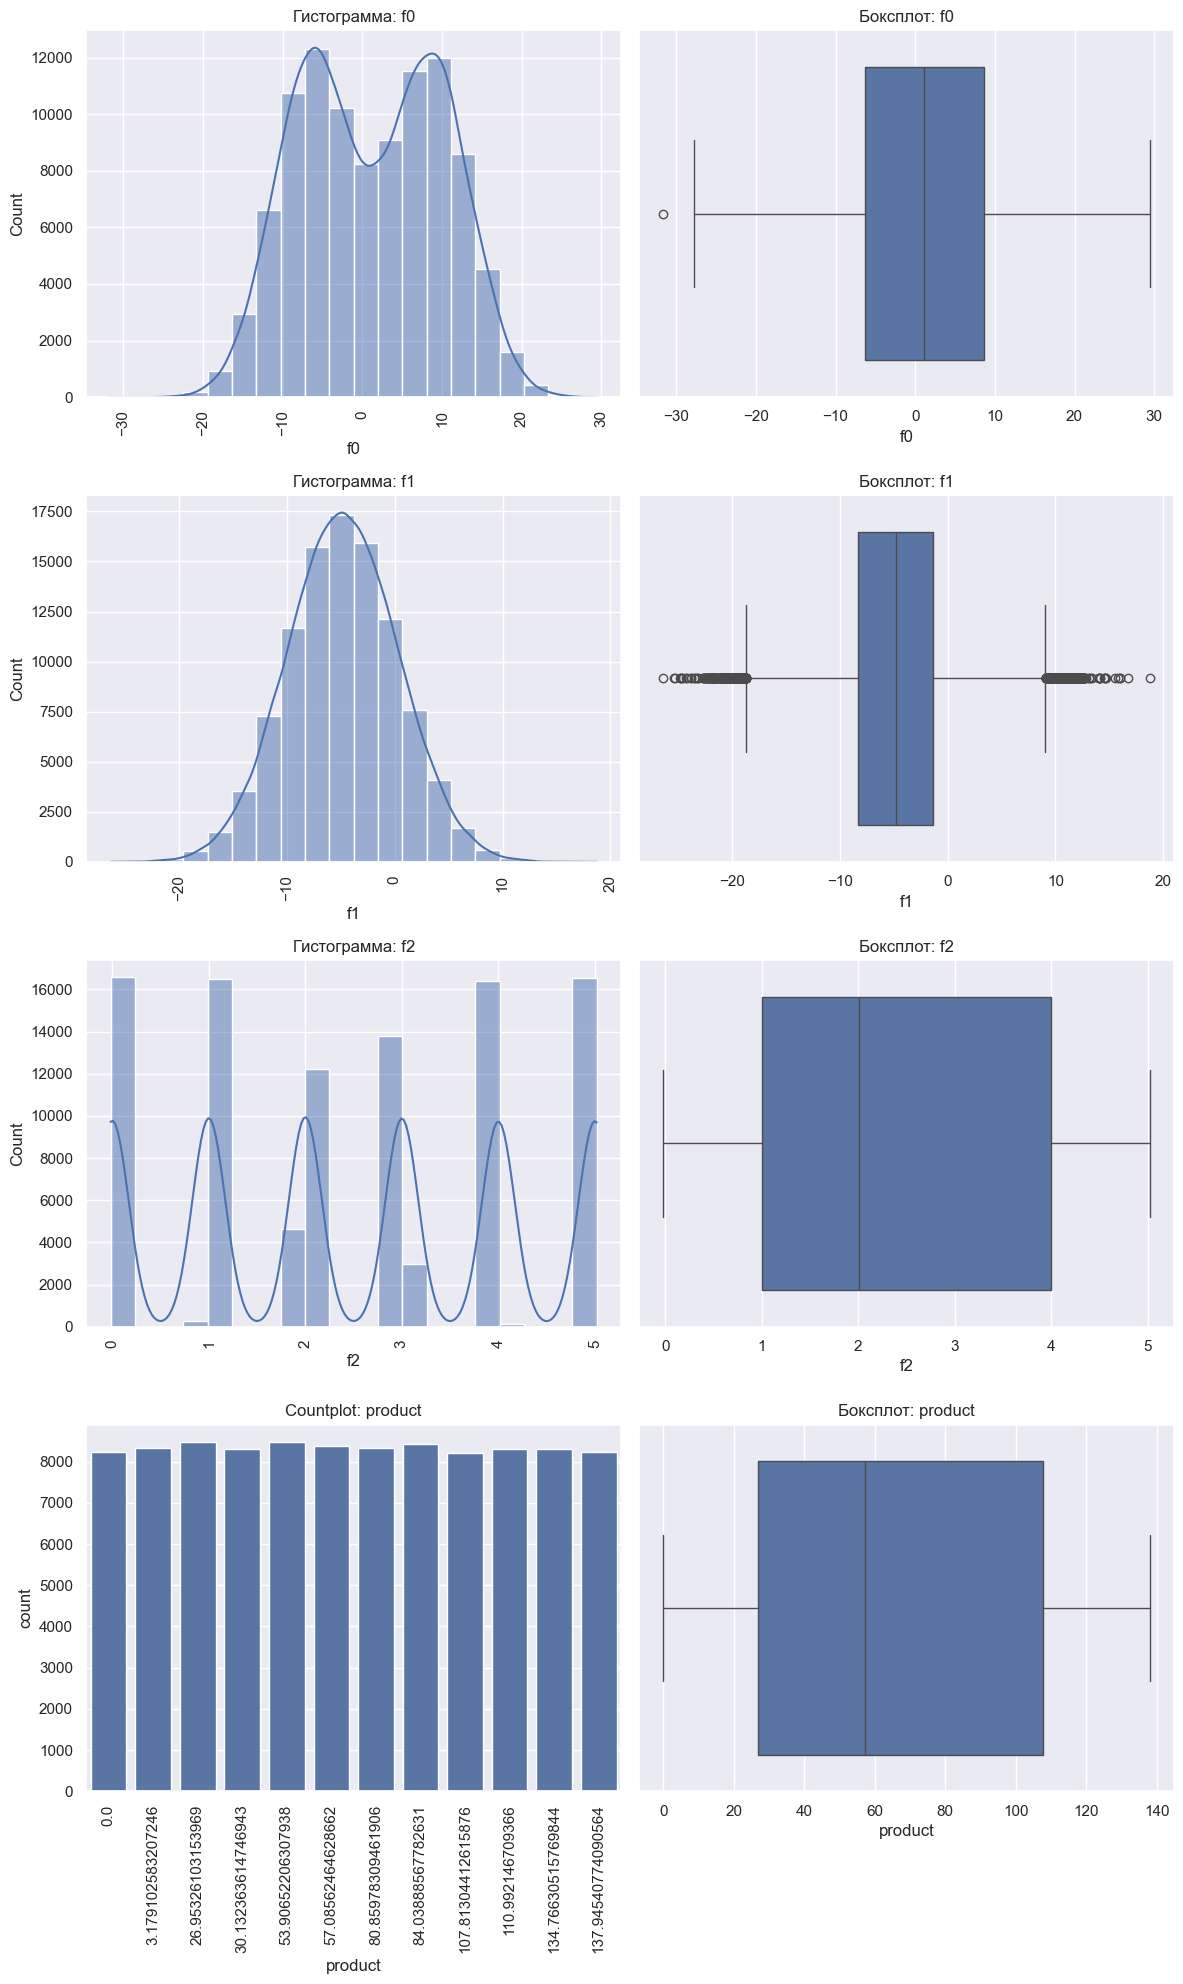

In [18]:
plot_combined(geo_data_1, col=None, target=None, col_type=None, legend_loc='best')

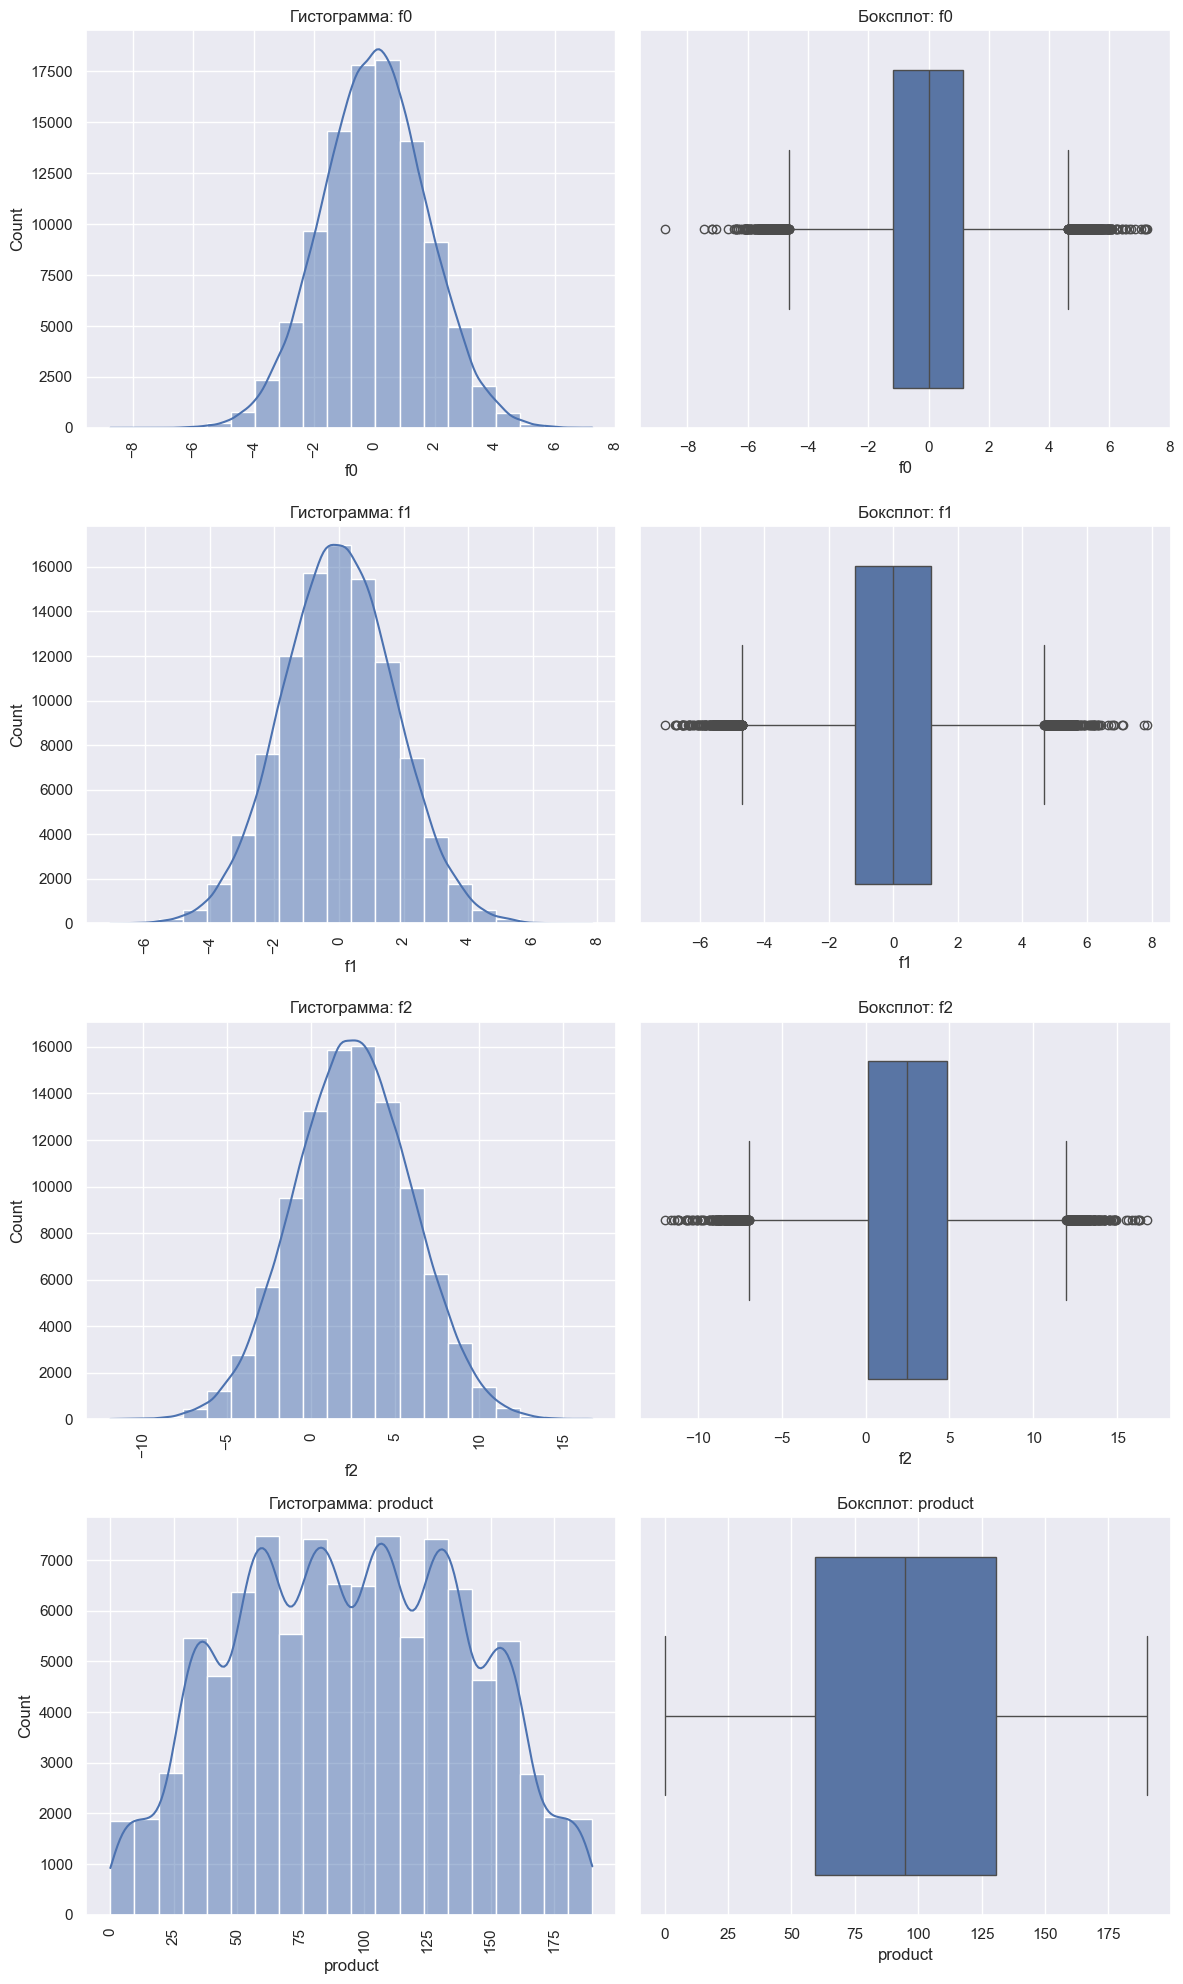

In [19]:
plot_combined(geo_data_2, col=None, target=None, col_type=None, legend_loc='best')

По всем регионам присутствуют нулевые выработки  
А регионе 1 их и вовсе почти 8000, не исключаем веротяность того, что эти разработки просто пустые...

In [20]:
display(geo_data_0[geo_data_0['product'] <= 0])
display(geo_data_1[geo_data_1['product'] <= 0])
display(geo_data_2[geo_data_2['product'] <= 0])

,id,f0,f1,f2,product
57263,zCM5W,-0.70,0.38,0.24,0.00


,id,f0,f1,f2,product
11,OXyvW,16.32,-0.56,-0.00,0.00
13,igmai,6.70,-0.75,-0.01,0.00
62,Qjy5w,21.42,-5.13,-0.00,0.00
63,G6WCj,6.82,3.10,-0.00,0.00
77,MzQhL,6.75,-11.89,-0.00,0.00
...,...,...,...,...,...
99936,YrRU8,5.09,-3.98,0.01,0.00
99948,Jbnur,8.28,-9.18,0.00,0.00
99956,aV1cJ,13.34,-1.29,0.01,0.00
99961,Zjbn2,13.85,-11.53,-0.01,0.00


,id,f0,f1,f2,product
68149,qeefd,-0.87,-1.62,-4.13,0.00


В 0 и 2 регионах таких данных по одной строчке и это не страшно  
А вот в регионе 1 таких строк слишком много и это указывает на то, что много пустых точек... 
У нас выбор не велик, пока оставим как есть

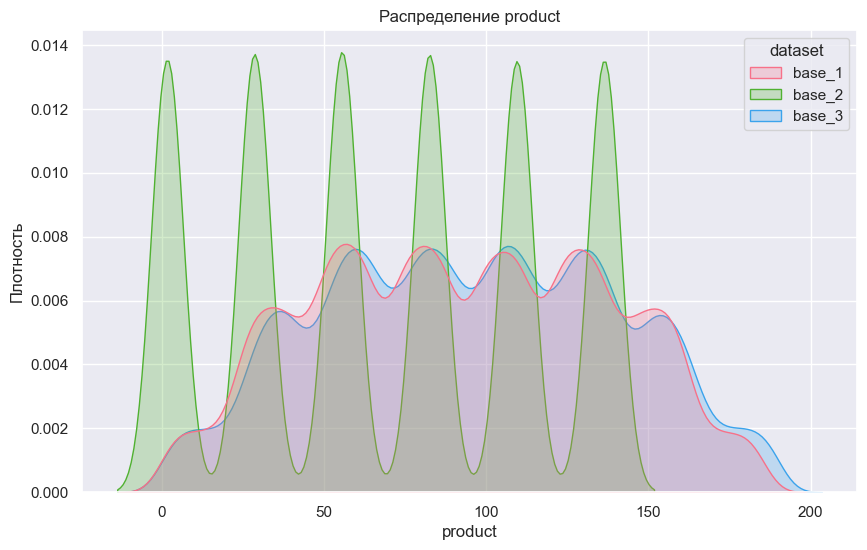

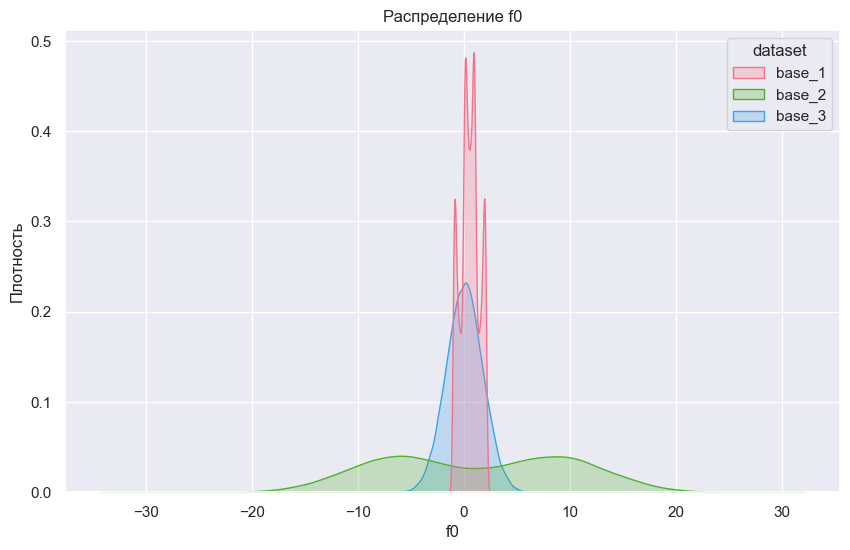

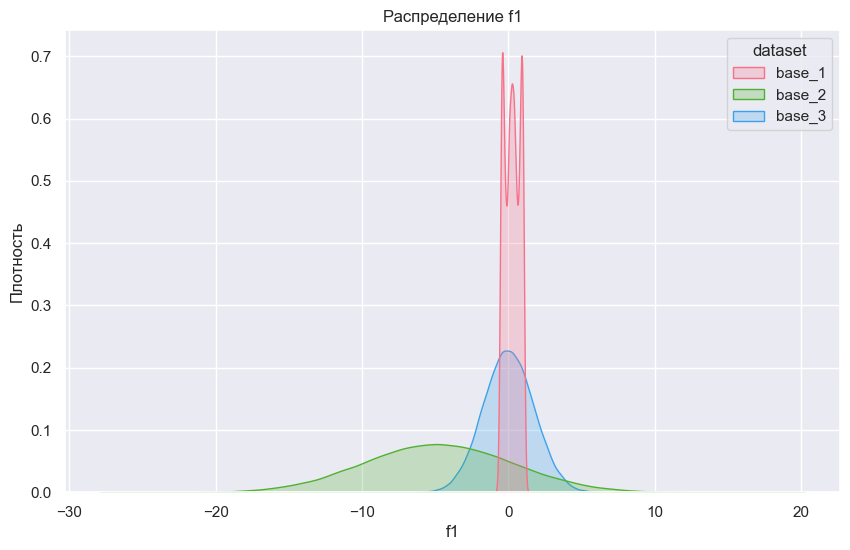

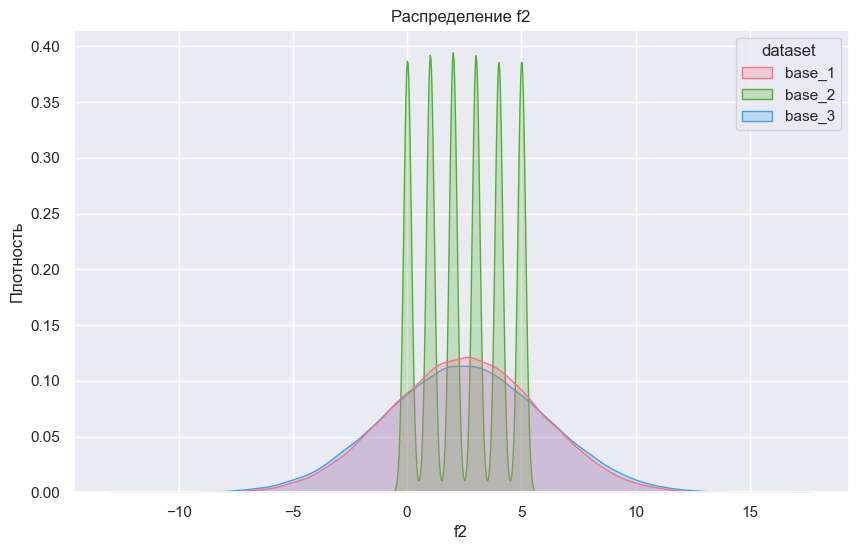

In [21]:
analyze_data([geo_data_0, geo_data_1, geo_data_2], ['id'])

Ну, тут можно сказать, что графики получились красивенькими, остальное я даже не знаю как оценивать, учитывая, что не важно, что они значат согласно ТЗ)))  

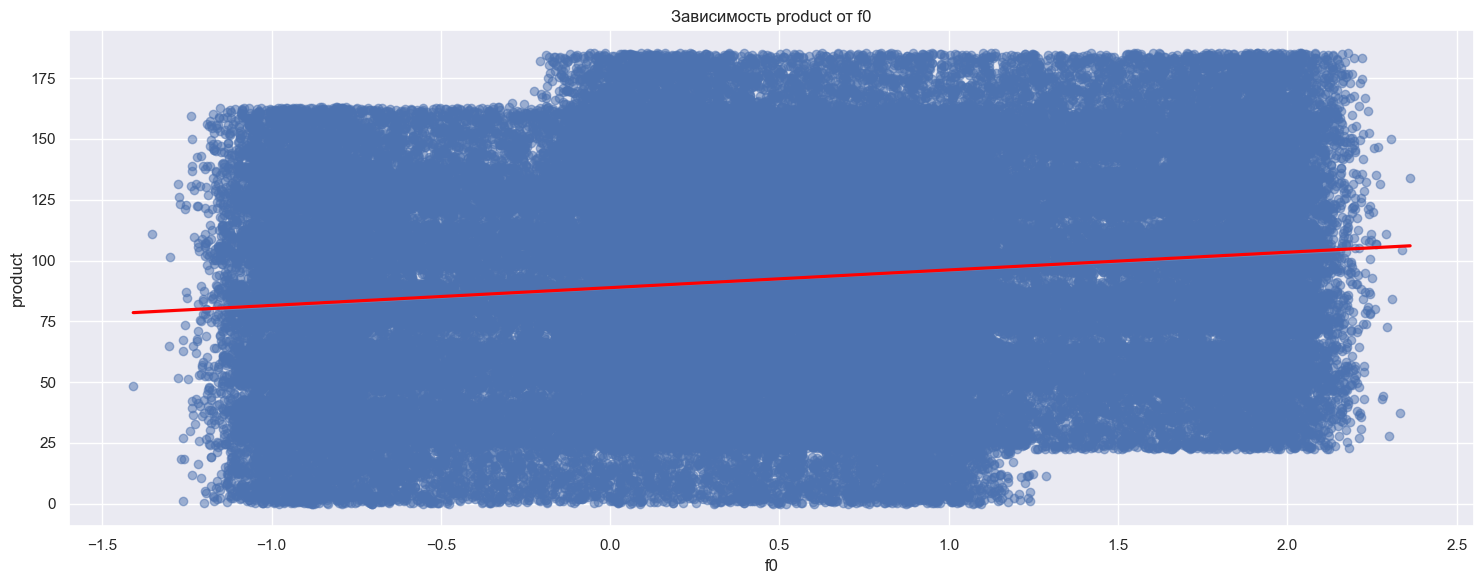

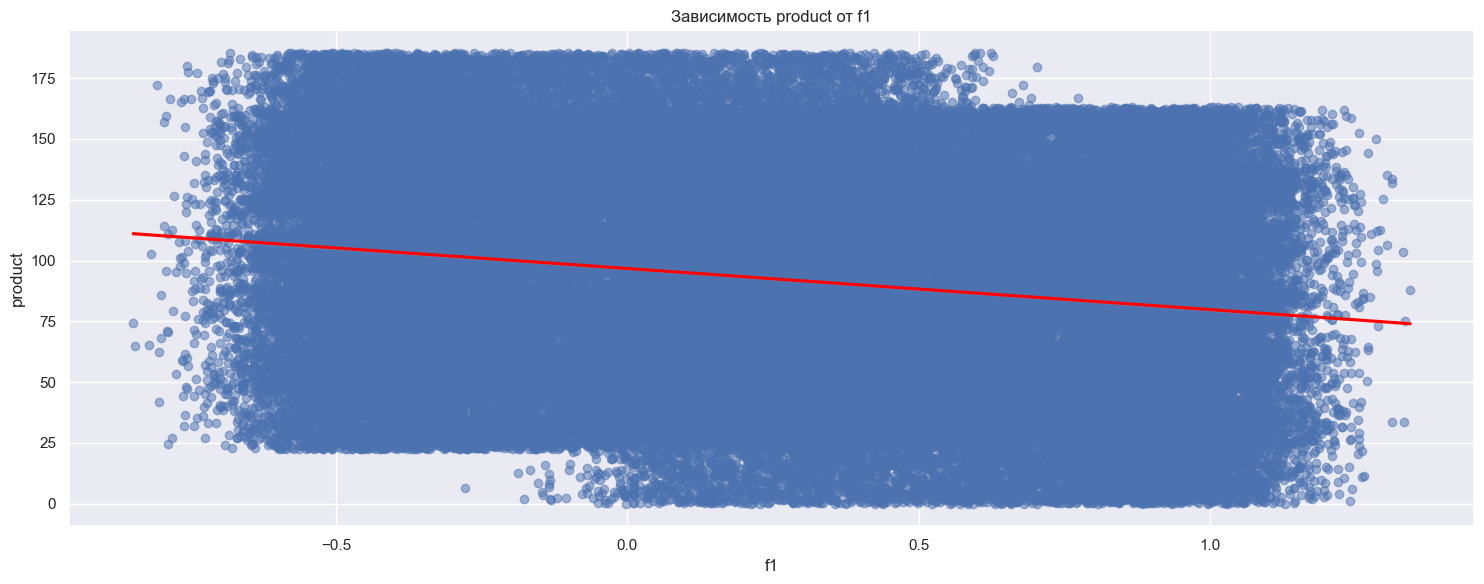

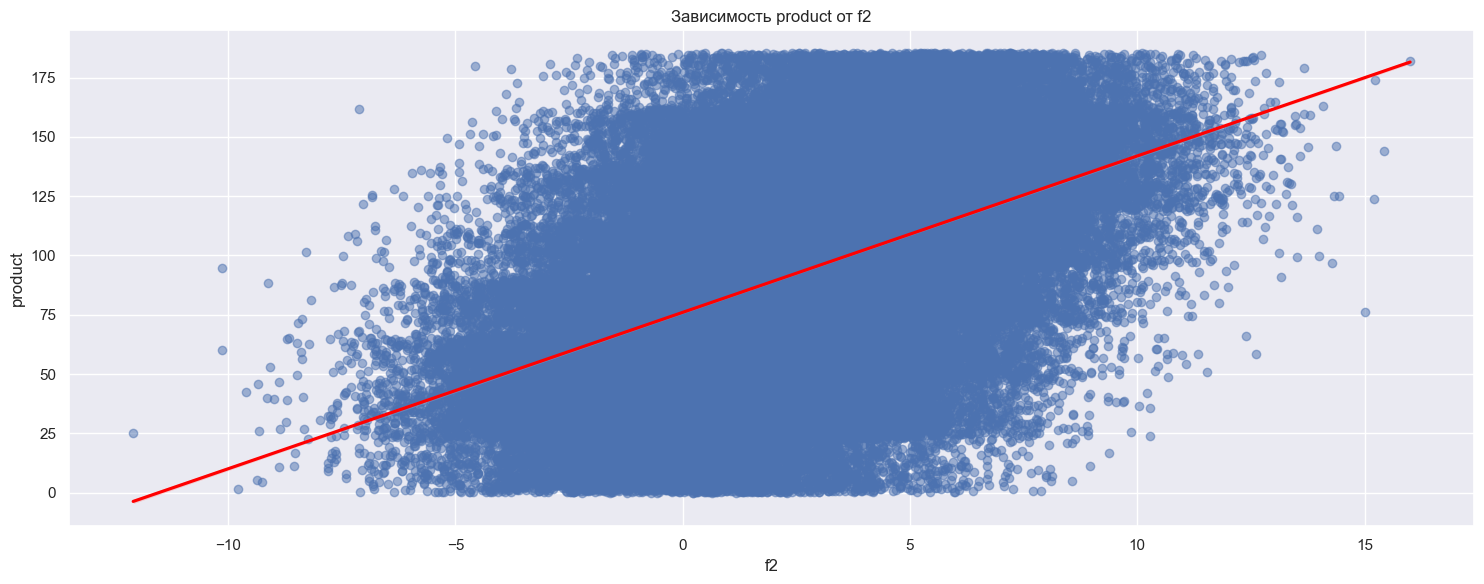

In [22]:
# отключу пока, а то долго что-то строится
plot_scatter_with_numerical(geo_data_0, 'product')

Графики показывают на явную линейную заивисимость между выработкой и данными о сырье

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


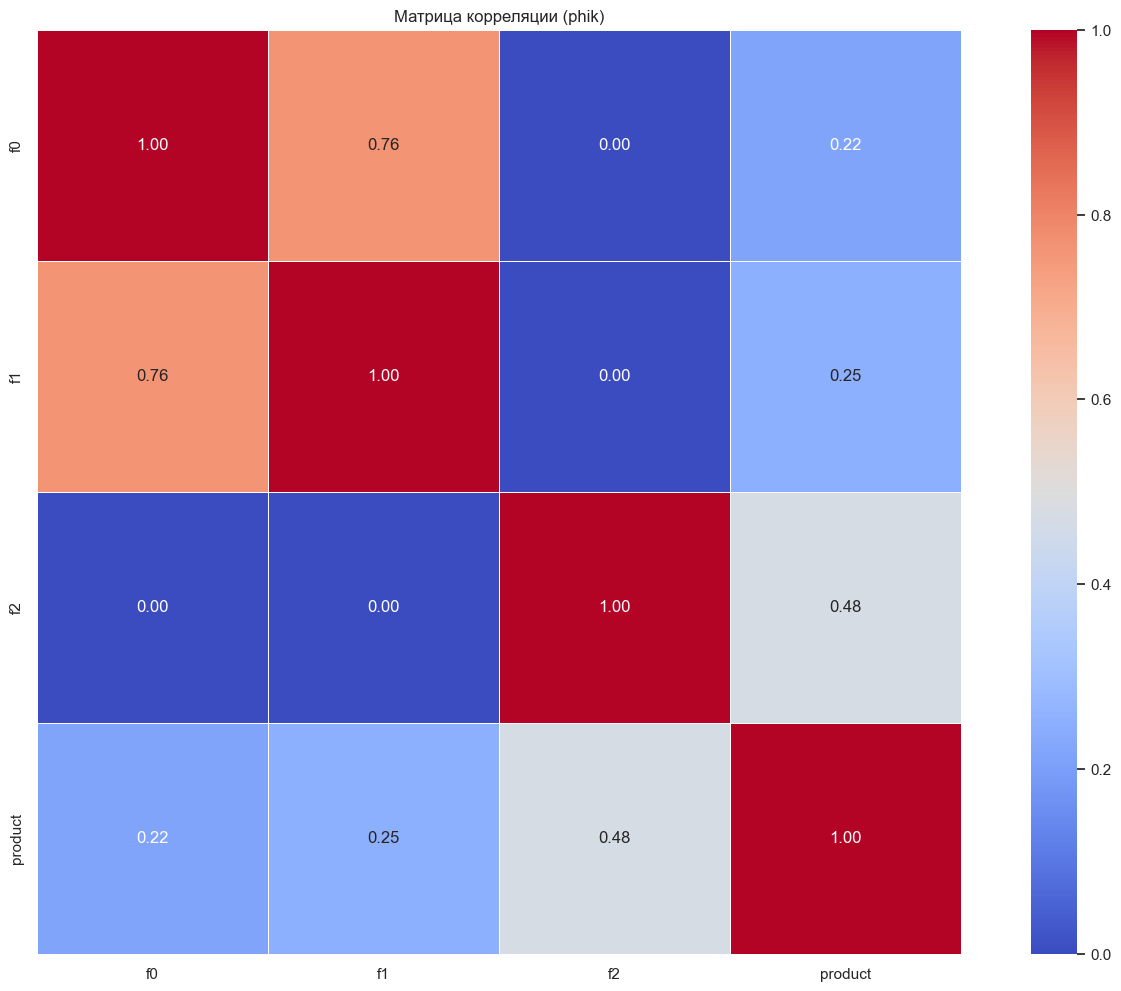

In [23]:
geo_data_0_cor = geo_data_0.drop(columns=['id'])
correlation_matrix = geo_data_0_cor.phik_matrix()

plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            square=True, 
            linecolor='white',
            linewidths=0.5)
plt.title('Матрица корреляции (phik)')
plt.show()

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


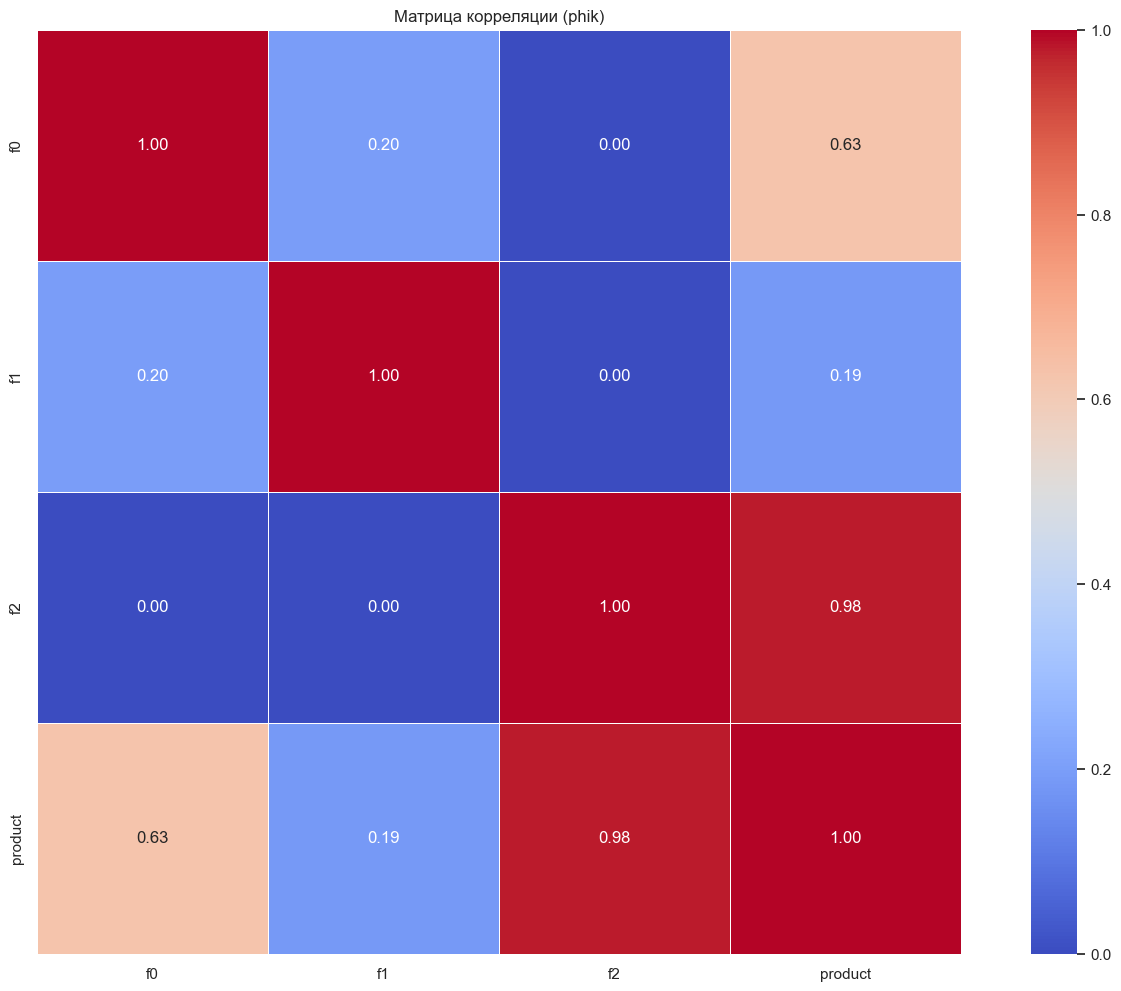

In [24]:
geo_data_1_cor = geo_data_1.drop(columns=['id'])
correlation_matrix = geo_data_1_cor.phik_matrix()

plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            square=True, 
            linecolor='white',
            linewidths=0.5)
plt.title('Матрица корреляции (phik)')
plt.show()

Здесь видим практически линейную зависимость между таргетом и признаком f2.

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


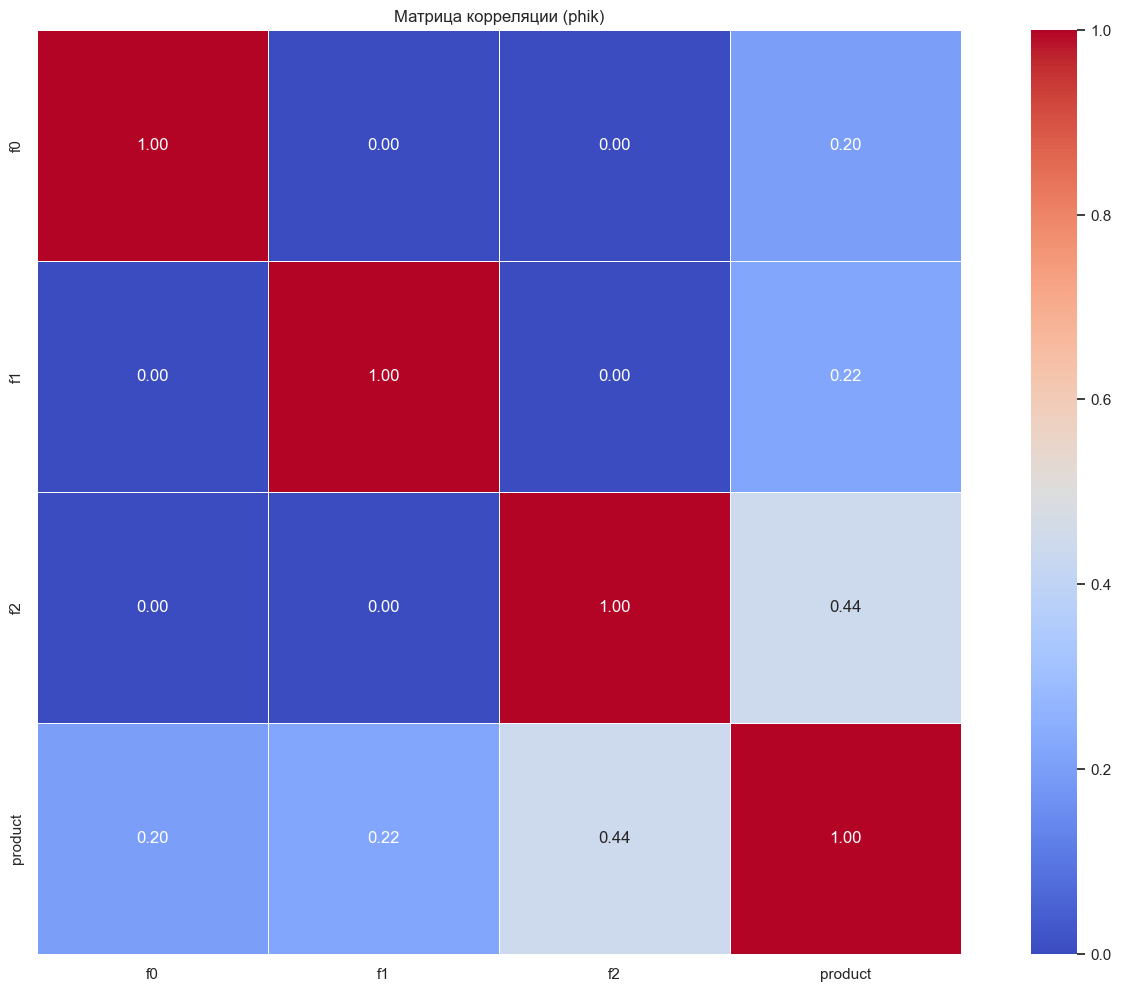

In [25]:
geo_data_2_cor = geo_data_2.drop(columns=['id'])
correlation_matrix = geo_data_2_cor.phik_matrix()

plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            square=True, 
            linecolor='white',
            linewidths=0.5)
plt.title('Матрица корреляции (phik)')
plt.show()

### Выводы

На данном этапе мы загрузили данные  
Проанализировали их и нашли неточности  
Во второй базе обнаружилась почти линейная зависимость между таргетом и признаком f2  
Мультиколлинеарности не наблюдается  

## Обучение моделей

### Регион 0

#### Обучение и проверка модели

In [26]:
target = 'product'
geo_data_0.set_index('id', inplace=True)
geo_data_1.set_index('id', inplace=True)
geo_data_2.set_index('id', inplace=True)

In [27]:
def expand_features(df, degree=2):
    product_column = df[['product']]
    features = df.drop(columns=['product'])
    
    poly = PolynomialFeatures(degree, include_bias=False)
    expanded_features = poly.fit_transform(features)
    
    expanded_df = pd.DataFrame(expanded_features, columns=poly.get_feature_names_out(features.columns), index=df.index)
    
    final_df = pd.concat([expanded_df, product_column], axis=1)
    
    return final_df

In [28]:
expanded_geo_data_0 = expand_features(geo_data_0)
expanded_geo_data_1 = expand_features(geo_data_1)
expanded_geo_data_2 = expand_features(geo_data_2)

interval columns not set, guessing: ['f0', 'f1', 'f2', 'f0^2', 'f0 f1', 'f0 f2', 'f1^2', 'f1 f2', 'f2^2', 'product']


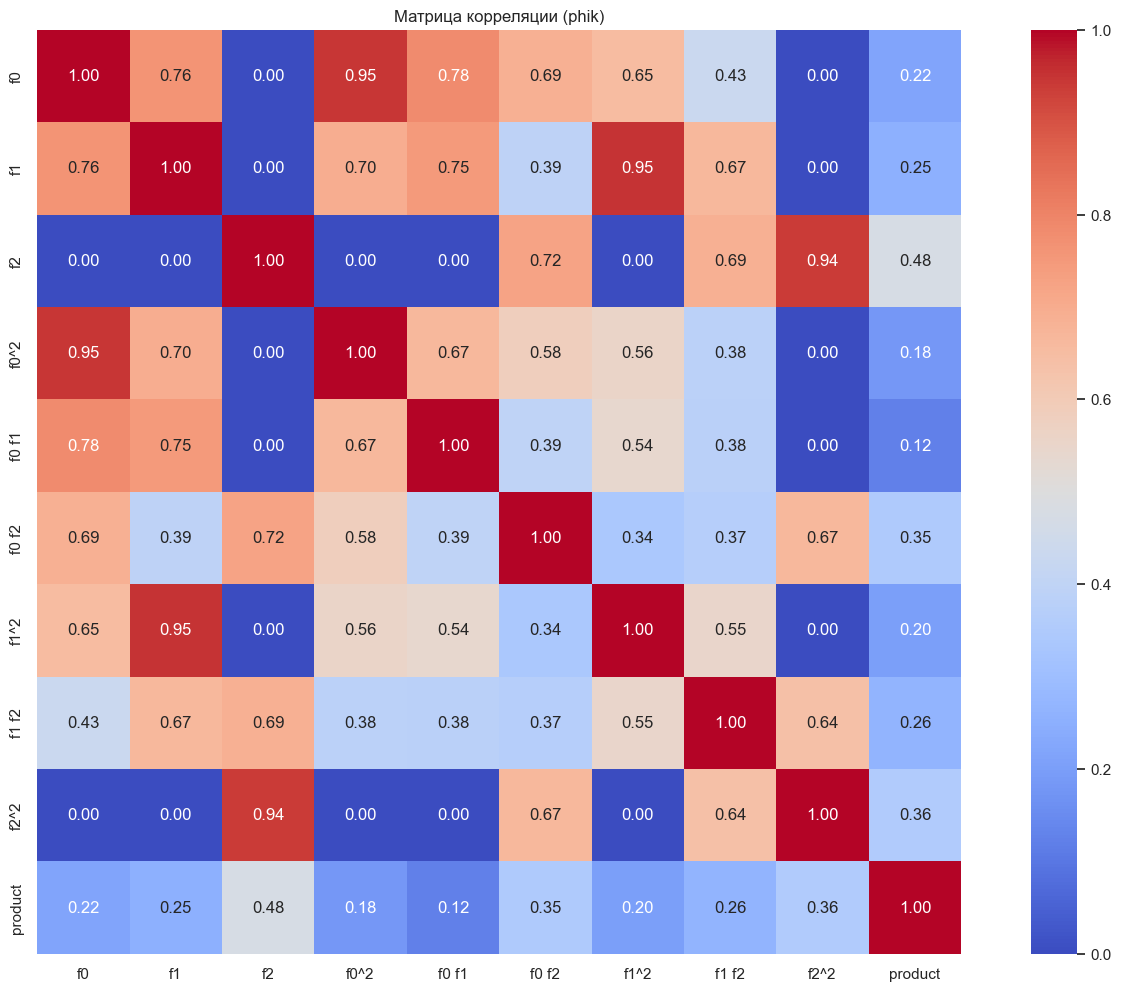

In [29]:
expanded_geo_data_0_cor = expanded_geo_data_0
correlation_matrix = expanded_geo_data_0_cor.phik_matrix()

plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            square=True, 
            linecolor='white',
            linewidths=0.5)
plt.title('Матрица корреляции (phik)')
plt.show()

interval columns not set, guessing: ['f0', 'f1', 'f2', 'f0^2', 'f0 f1', 'f0 f2', 'f1^2', 'f1 f2', 'f2^2', 'product']


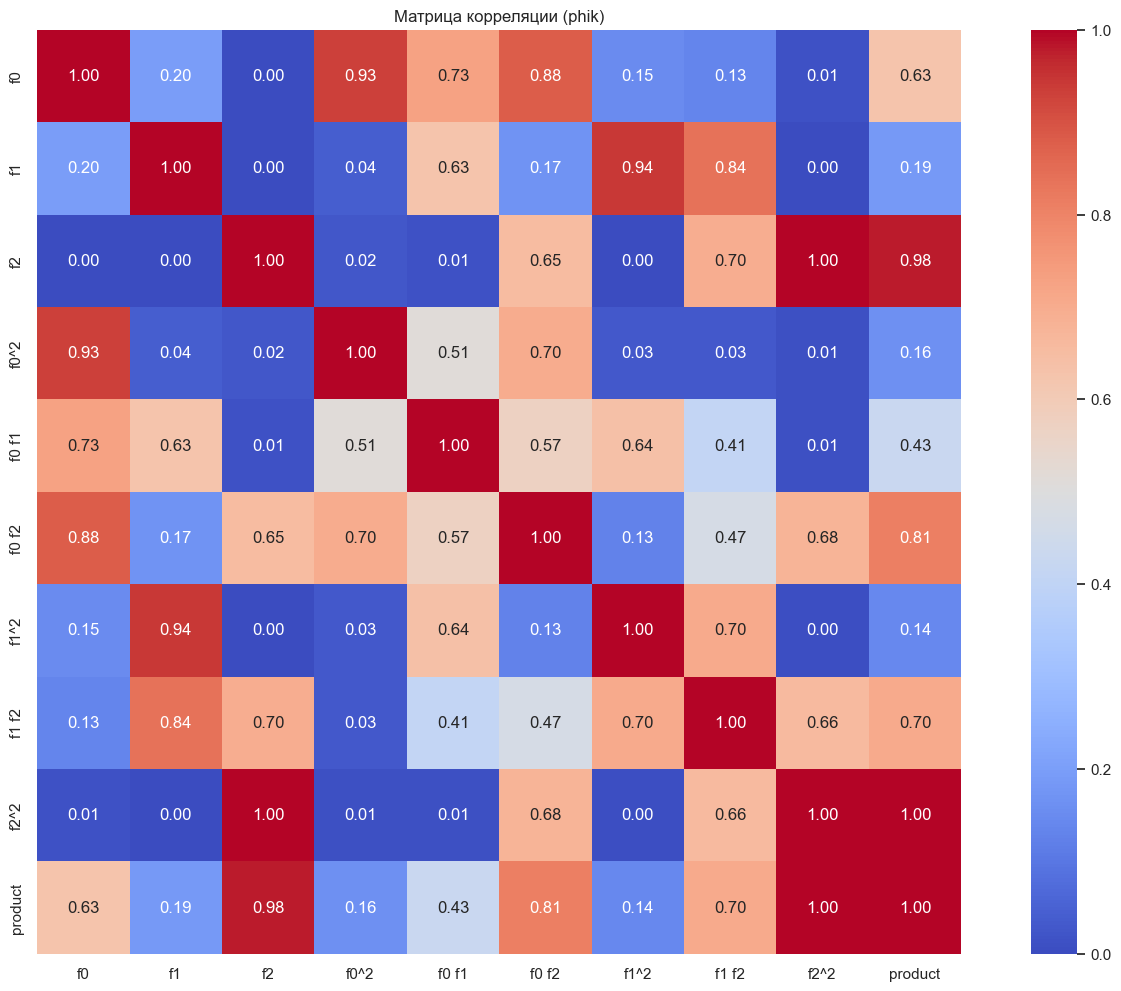

In [30]:
expanded_geo_data_1_cor = expanded_geo_data_1
correlation_matrix = expanded_geo_data_1_cor.phik_matrix()

plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            square=True, 
            linecolor='white',
            linewidths=0.5)
plt.title('Матрица корреляции (phik)')
plt.show()

interval columns not set, guessing: ['f0', 'f1', 'f2', 'f0^2', 'f0 f1', 'f0 f2', 'f1^2', 'f1 f2', 'f2^2', 'product']


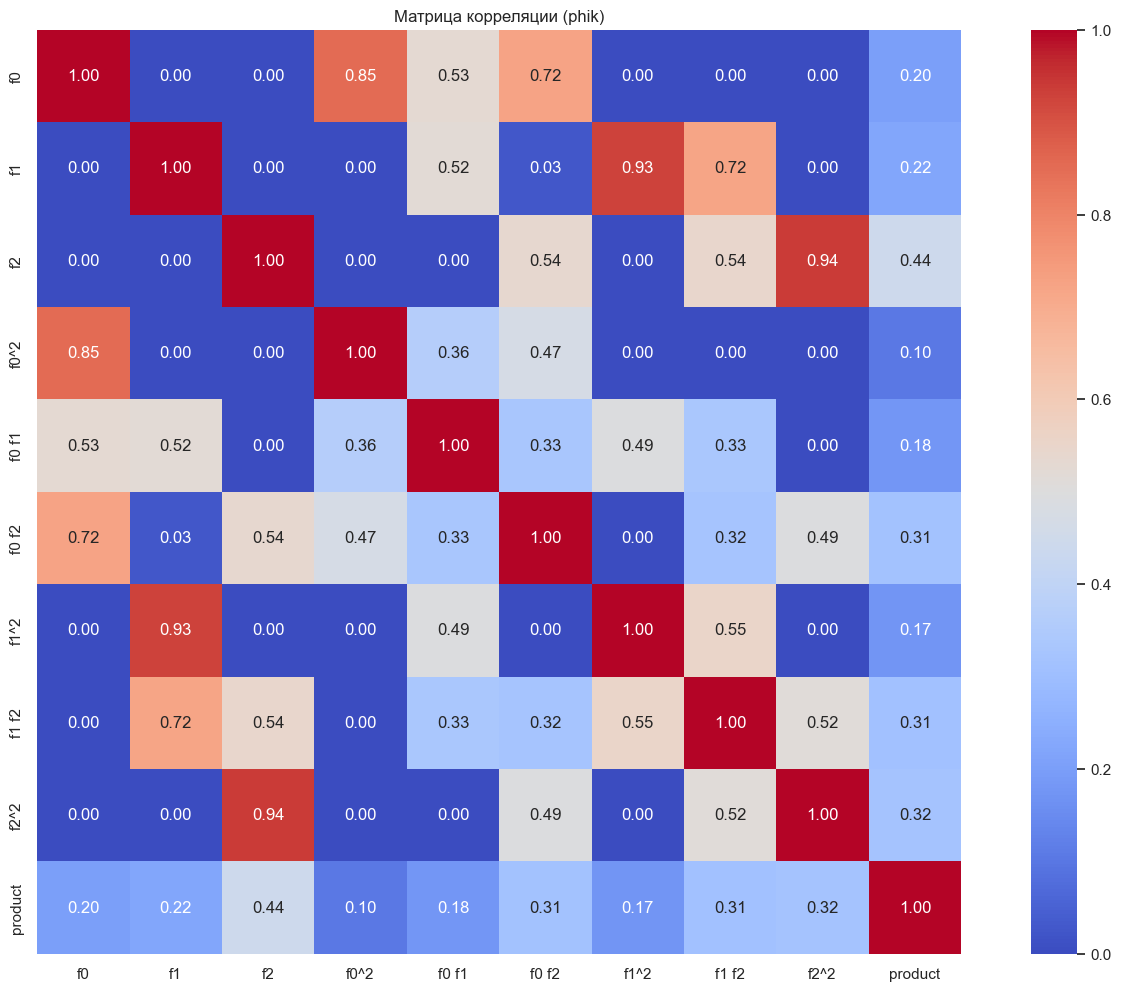

In [31]:
expanded_geo_data_2_cor = expanded_geo_data_2
correlation_matrix = expanded_geo_data_2_cor.phik_matrix()

plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            square=True, 
            linecolor='white',
            linewidths=0.5)
plt.title('Матрица корреляции (phik)')
plt.show()

##### Подготовка к обучению регион 0

In [32]:
X, y = get_target(expanded_geo_data_0, target)

scaler_0 = StandardScaler()
X_scaled = scaler_0.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

In [33]:
X_train.shape, X_test.shape

((74992, 9), (24998, 9))

In [34]:
y_train.shape, y_test.shape

((74992,), (24998,))

##### Обучение модели

'Проверим как обучилась модель:'

'Реальное значение: 102.33953761894443, Предсказанное значение: 71.96985817503597'

'Реальное значение: 25.23107971877318, Предсказанное значение: 86.81472556600767'

'r2_0 - 0.2674432952482606'

'mae_0 - 31.079452887598954'

'mse_0 - 1427.2353266856048'

'rmse_0 - 37.778768199685985'

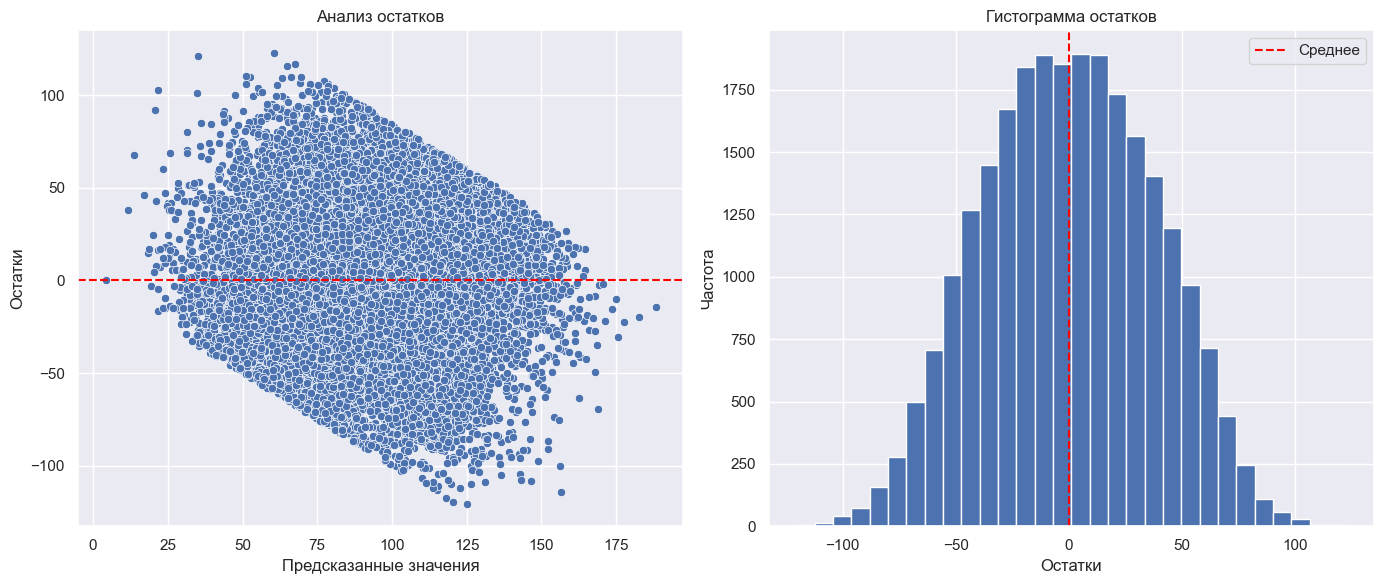

In [35]:
model_lr_0 = get_model_lin_reg(X_train, y_train)

r2_0 = get_r2(model_lr_0, X_test, y_test)
display(f"r2_0 - {r2_0}")

mae_0 = get_mae(model_lr_0, X_test, y_test)
display(f"mae_0 - {mae_0}")

mse_0 = get_mse(model_lr_0, X_test, y_test)
display(f"mse_0 - {mse_0}")

rmse_0 = get_rmse(model_lr_0, X_test, y_test)
display(f"rmse_0 - {rmse_0}")

get_rest(model_lr_0, X_test, y_test)

In [36]:
predictions = model_lr_0.predict(X_test)
results_0 = pd.DataFrame({
    'product': y_test,
    'product_predict': predictions
})

display(results_0.sample(5))

,product,product_predict
id,,
aTPaz,52.75,100.89
Xi7Xm,122.16,61.19
vZKCN,37.64,105.47
lqfYZ,122.56,97.54
Me3xC,97.80,140.24


In [37]:
mean_prod_0 = np.mean(predictions)
display("Средний запас предсказанного сырья:", mean_prod_0)
display("RMSE:", rmse_0)

'Средний запас предсказанного сырья:'

92.46588162515881

'RMSE:'

37.778768199685985

### Регион 1

#### Обучение и проверка модели

##### Подготовка к обучению регион 1

In [38]:
X, y = get_target(expanded_geo_data_1, target)

scaler_1 = StandardScaler()
X_scaled = scaler_1.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

##### Обучение модели

'Проверим как обучилась модель:'

'Реальное значение: 0.0, Предсказанное значение: -0.17664466671068624'

'Реальное значение: 3.179102583207246, Предсказанное значение: 3.2709175936359856'

'r2_1 - 0.9996271809449675'

'mae_1 - 0.7184343498756932'

'mse_1 - 0.7938716634182991'

'rmse_1 - 0.8909947606009246'

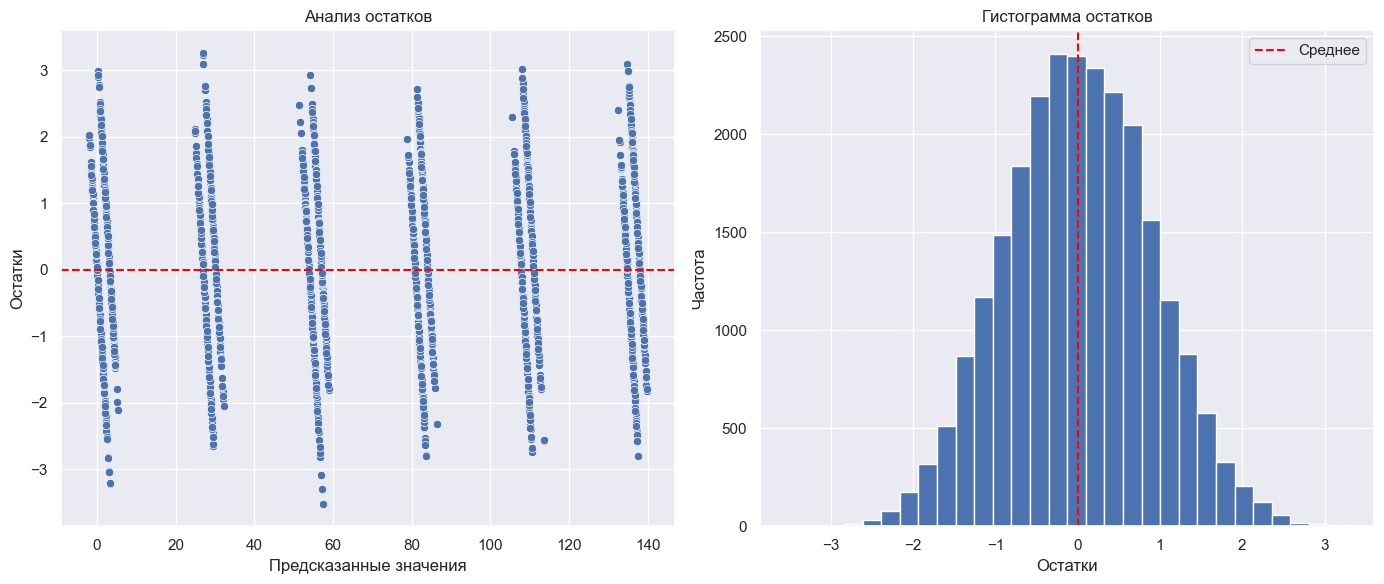

In [39]:
model_lr_1 = get_model_lin_reg(X_train, y_train)

r2_1 = get_r2(model_lr_1, X_test, y_test)
display(f"r2_1 - {r2_1}")

mae_1 = get_mae(model_lr_1, X_test, y_test)
display(f"mae_1 - {mae_1}")

mse_1 = get_mse(model_lr_1, X_test, y_test)
display(f"mse_1 - {mse_1}")

rmse_1 = get_rmse(model_lr_1, X_test, y_test)
display(f"rmse_1 - {rmse_1}")

get_rest(model_lr_1, X_test, y_test)

In [40]:
predictions = model_lr_1.predict(X_test)
results_1 = pd.DataFrame({
    'product': y_test,
    'product_predict': predictions
})

display(results_1.sample(5))

,product,product_predict
id,,
57MQD,134.77,137.25
NFOCm,84.04,83.76
9FB2u,80.86,81.95
2KwXO,137.95,137.46
7fMCb,26.95,26.43


In [41]:
mean_prod_1 = np.mean(predictions)
display("Средний запас предсказанного сырья:", mean_prod_1)
display("RMSE:", rmse_1)

'Средний запас предсказанного сырья:'

68.56966307874147

'RMSE:'

0.8909947606009246

### Регион 2

#### Обучение и проверка модели

##### Подготовка к обучению регион 2

In [42]:
X, y = get_target(expanded_geo_data_2, target)

scaler_2 = StandardScaler()
X_scaled = scaler_2.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

##### Обучение модели

'Проверим как обучилась модель:'

'Реальное значение: 85.30326568068692, Предсказанное значение: 78.4529476568981'

'Реальное значение: 143.990402345012, Предсказанное значение: 92.70848327879892'

'r2_2 - 0.253768103669041'

'mae_2 - 31.825373113379374'

'mse_2 - 1490.4099295642059'

'rmse_2 - 38.60582766324543'

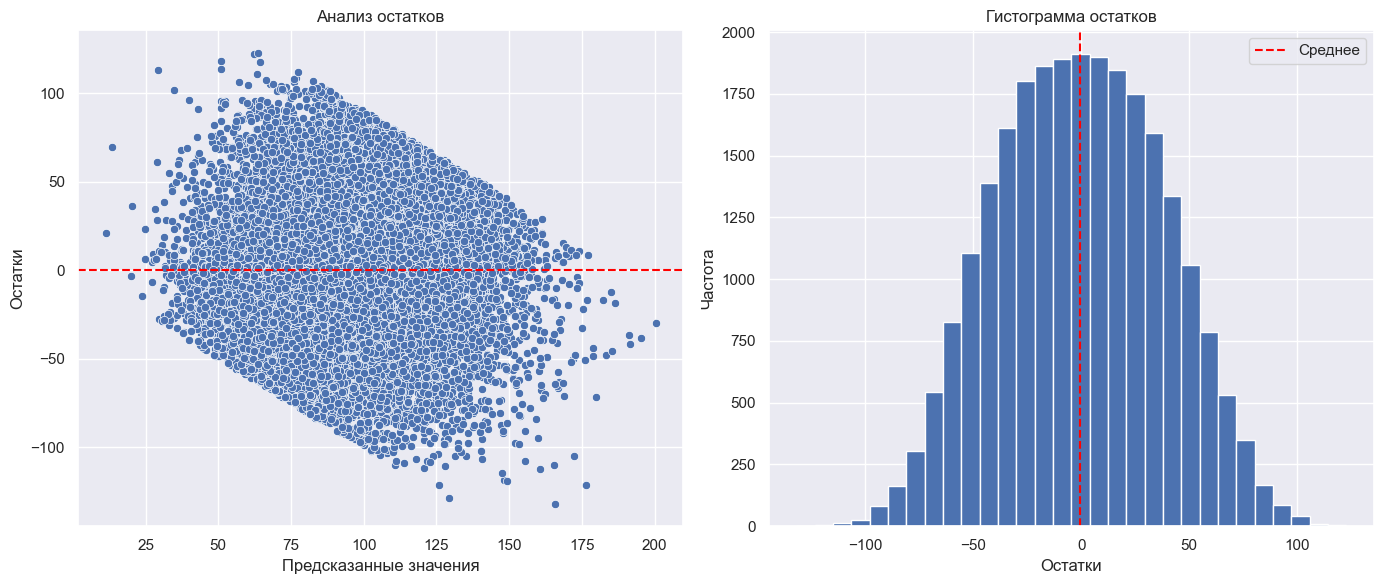

In [43]:
model_lr_2 = get_model_lin_reg(X_train, y_train)

r2_2 = get_r2(model_lr_2, X_test, y_test)
display(f"r2_2 - {r2_2}")

mae_2 = get_mae(model_lr_2, X_test, y_test)
display(f"mae_2 - {mae_2}")

mse_2 = get_mse(model_lr_2, X_test, y_test)
display(f"mse_2 - {mse_2}")

rmse_2 = get_rmse(model_lr_2, X_test, y_test)
display(f"rmse_2 - {rmse_2}")

get_rest(model_lr_2, X_test, y_test)

In [44]:
predictions = model_lr_2.predict(X_test)
results_2 = pd.DataFrame({
    'product': y_test,
    'product_predict': predictions
})

display(results_2.sample(5))

,product,product_predict
id,,
oKp5v,75.53,79.22
K4C9a,141.68,95.12
4jdOd,114.24,74.51
TdH1J,151.34,117.45
tEw7V,151.04,140.56


In [45]:
mean_prod_2 = np.mean(predictions)
display("Средний запас предсказанного сырья:", mean_prod_2)
display("RMSE:", rmse_2)

'Средний запас предсказанного сырья:'

95.06786828696727

'RMSE:'

38.60582766324543

### Выводы

In [46]:
result_data = pd.DataFrame({
    'Model': ['Geo_0', 'Geo_1', 'Geo_2'],
    'R2': [r2_0, r2_1, r2_2],
    'MAE': [mae_0, mae_1, mae_2],
    'MSE': [mse_0, mse_1, mse_2],
    'RMSE': [rmse_0, rmse_1, rmse_2],
    'mean_prod': [mean_prod_0, mean_prod_1, mean_prod_2]
})

result_data.set_index('Model', inplace=True)

display(result_data)

,R2,MAE,MSE,RMSE,mean_prod
Model,,,,,
Geo_0,0.27,31.08,1427.24,37.78,92.47
Geo_1,1.00,0.72,0.79,0.89,68.57
Geo_2,0.25,31.83,1490.41,38.61,95.07


Обучив модели по 3м регионам - получилось, что лучше всего себя показывает модель по первому региону.  
Также по результатам обучения мы получили среднюю выработку по локациям и вот такой я бы сделал ТОП:  
1) Регион 1 - меньший разброс предсказания и высокий показатель метрик;  
2) Регион 0 - немного лучше Региона 2;
3) Регион 2 - наименее предпочтительный.

## Подготовка к расчёту прибыли

### Константы

In [47]:
MAX_DOTS = 500
BEST_DOTS = 200
BUDGET = 10_000_000_000
ONE_VALUES_PRICE = 450_000
RISK = 2.5

### Расчеты

In [48]:
profit_from_dot = BUDGET / BEST_DOTS
display(f"Порог безубыточности с одной точки по локации составляет: {round(profit_from_dot, 2)} рублей")

min_prod_from_dot = profit_from_dot / ONE_VALUES_PRICE
display(f"Порог безубыточности с одной точки по локации составляет: {round(min_prod_from_dot, 2)} тыс. барелей нефти")

min_prod_from_region = min_prod_from_dot * BEST_DOTS
display(f"Порог безубыточности с одного региона составляет: {round(min_prod_from_region, 2)} тыс. барелей нефти")

'Порог безубыточности с одной точки по локации составляет: 50000000.0 рублей'

'Порог безубыточности с одной точки по локации составляет: 111.11 тыс. барелей нефти'

'Порог безубыточности с одного региона составляет: 22222.22 тыс. барелей нефти'

Посчитаем средний объем продукции со всех точек в каждом из регионов

In [49]:
mean_prod_0 = np.mean(geo_data_0['product'])
mean_prod_1 = np.mean(geo_data_1['product'])
mean_prod_2 = np.mean(geo_data_2['product'])

In [50]:
means = [mean_prod_0, mean_prod_1, mean_prod_2]
for index, value in enumerate(means):
    display(f'Регион {index}, средний запас {round(value, 2)}')
    if min_prod_from_dot > value:
        display(f'убыточный')
    else:
        display(f'прибыльный')

'Регион 0, средний запас 92.5'

'убыточный'

'Регион 1, средний запас 68.82'

'убыточный'

'Регион 2, средний запас 95.0'

'убыточный'

### Выводы

Таким образом, после предварительных рассчетов - у нас все регионы оказались убыточными, если брать средние показатели по всем точкам  
Но ведь у нас там 100000 точек, какие-то меньше приносят, какие-то больше - поэтому некорректно будет сразу отвергать все регионы, будем считать дальше

## Функция расчета прибыли

In [51]:
def profit(data):
    best_200 = data.nlargest(BEST_DOTS, 'product_predict')
    profit_value = sum(best_200['product']) * ONE_VALUES_PRICE - BUDGET
    return profit_value

## Расчёт прибыли

### Расчет прибыли

Посчитаем реальный профит с добычи по регионам по имеющимся данным

In [52]:
profit_0 = sum(geo_data_0['product']) * ONE_VALUES_PRICE - BUDGET
formatted_profit_0 = f"{profit_0:,.2f}"
display(formatted_profit_0)

'4,152,069,541,219.48'

In [53]:
profit_1 = sum(geo_data_1['product']) * ONE_VALUES_PRICE - BUDGET
formatted_profit_1 = f"{profit_1:,.2f}"
display(formatted_profit_1)

'3,086,952,333,263.18'

Вот и всплыло то, что слишком много нулевых значений по базе, показатели значительно ниже чем в других регионах

In [54]:
profit_2 = sum(geo_data_2['product']) * ONE_VALUES_PRICE - BUDGET
formatted_profit_2 = f"{profit_2:,.2f}"
display(formatted_profit_2)

'4,264,754,398,354.21'

### Выводы

In [55]:
profits = [profit_0, profit_1, profit_2]
max_profit = max(profits)
max_index = profits.index(max_profit)

formatted_profit = f"{max_profit:,.2f}"

display(f'Лидирует регион {max_index} с прибылью в {formatted_profit} рублей')


'Лидирует регион 2 с прибылью в 4,264,754,398,354.21 рублей'

## Рарсчет рисков и прибыли для каждого региона

In [56]:
def bootstrap_profit(data, n_bootstrap=1000):
    profits = []
    rng = np.random.RandomState(RANDOM_STATE)

    for _ in tqdm(range(n_bootstrap), desc='Bootstrapping profits'):
        sample = data.sample(n=MAX_DOTS, replace=True, random_state=rng)
        profit_value = profit(sample)
        profits.append(profit_value)
    
    return np.array(profits)

profits_0 = bootstrap_profit(results_0)
profits_1 = bootstrap_profit(results_1)
profits_2 = bootstrap_profit(results_2)

Bootstrapping profits: 100%|█████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2483.43it/s]


In [57]:
def print_metrics(profits, region_name):
    mean_profit = int(round(np.mean(profits)))
    ci_low = int(round(np.percentile(profits, 2.5)))
    ci_high = int(round(np.percentile(profits, 97.5)))
    
    num_losses = (profits < 0).sum()
    total_samples = len(profits)
    loss_risk = round(num_losses / total_samples * 100, 1) if total_samples > 0 else 0
    
    mean_profit_str = f"{mean_profit:,.2f}"
    ci_low_str = f"{ci_low:,.2f}"
    ci_high_str = f"{ci_high:,.2f}"
    
    display(f"Регион {region_name}:")
    display(f"- Средняя прибыль: {mean_profit_str} руб.")
    display(f"- 95% доверительный интервал: [{ci_low_str}, {ci_high_str}] руб.")
    display(f"- Риск убытков: {loss_risk}%")
    display(f"- Количество убытков: {num_losses}, Всего: {total_samples}")
    display("------")

print_metrics(profits_0, "0")
print_metrics(profits_1, "1")
print_metrics(profits_2, "2")

'Регион 0:'

'- Средняя прибыль: 365,479,577.00 руб.'

'- 95% доверительный интервал: [-144,450,099.00, 870,168,242.00] руб.'

'- Риск убытков: 7.9%'

'- Количество убытков: 79, Всего: 1000'

'------'

'Регион 1:'

'- Средняя прибыль: 462,298,055.00 руб.'

'- 95% доверительный интервал: [73,130,804.00, 851,622,361.00] руб.'

'- Риск убытков: 1.1%'

'- Количество убытков: 11, Всего: 1000'

'------'

'Регион 2:'

'- Средняя прибыль: 537,441,516.00 руб.'

'- 95% доверительный интервал: [23,459,311.00, 1,072,662,725.00] руб.'

'- Риск убытков: 2.1%'

'- Количество убытков: 21, Всего: 1000'

'------'

И для наглядности

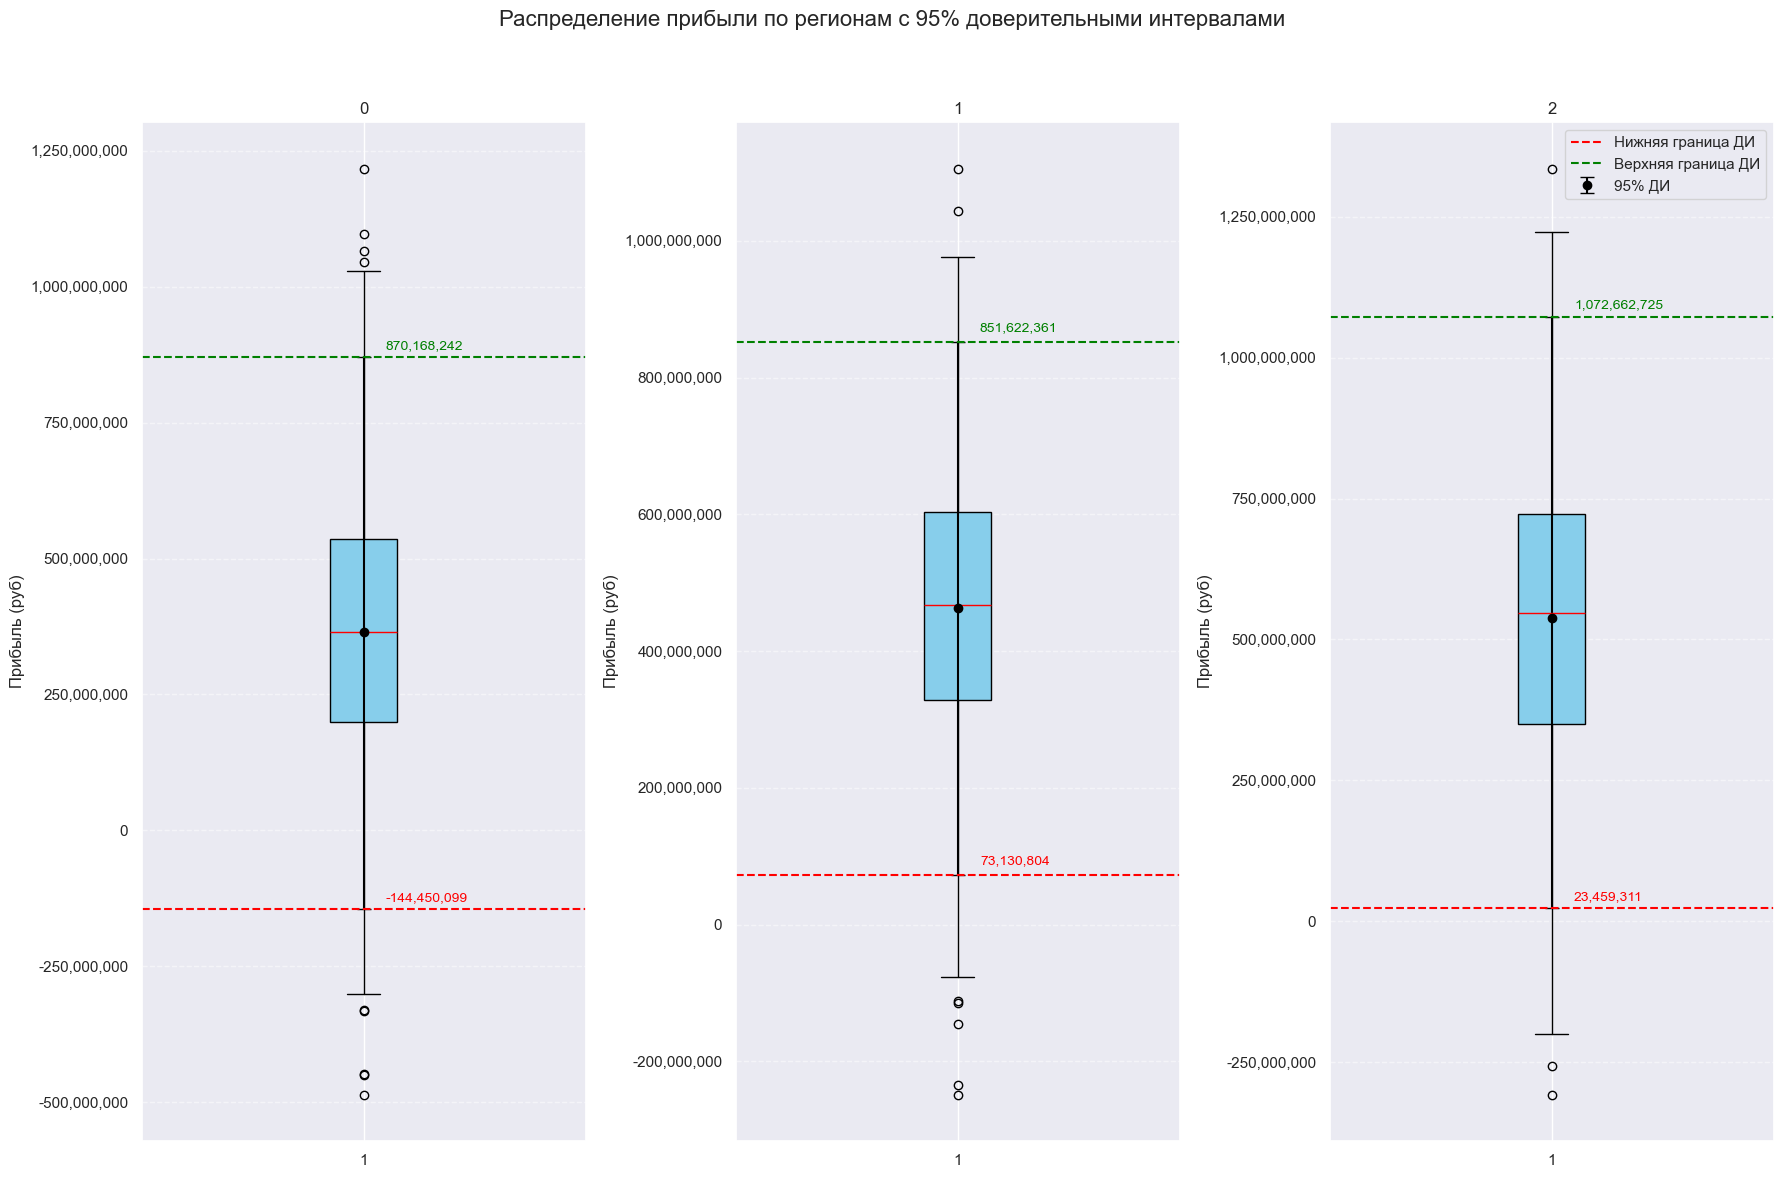

In [58]:
profits_list = [profits_0, profits_1, profits_2]
region_names = ["0", "1", "2"]
visualize_profits(profits_list, region_names)

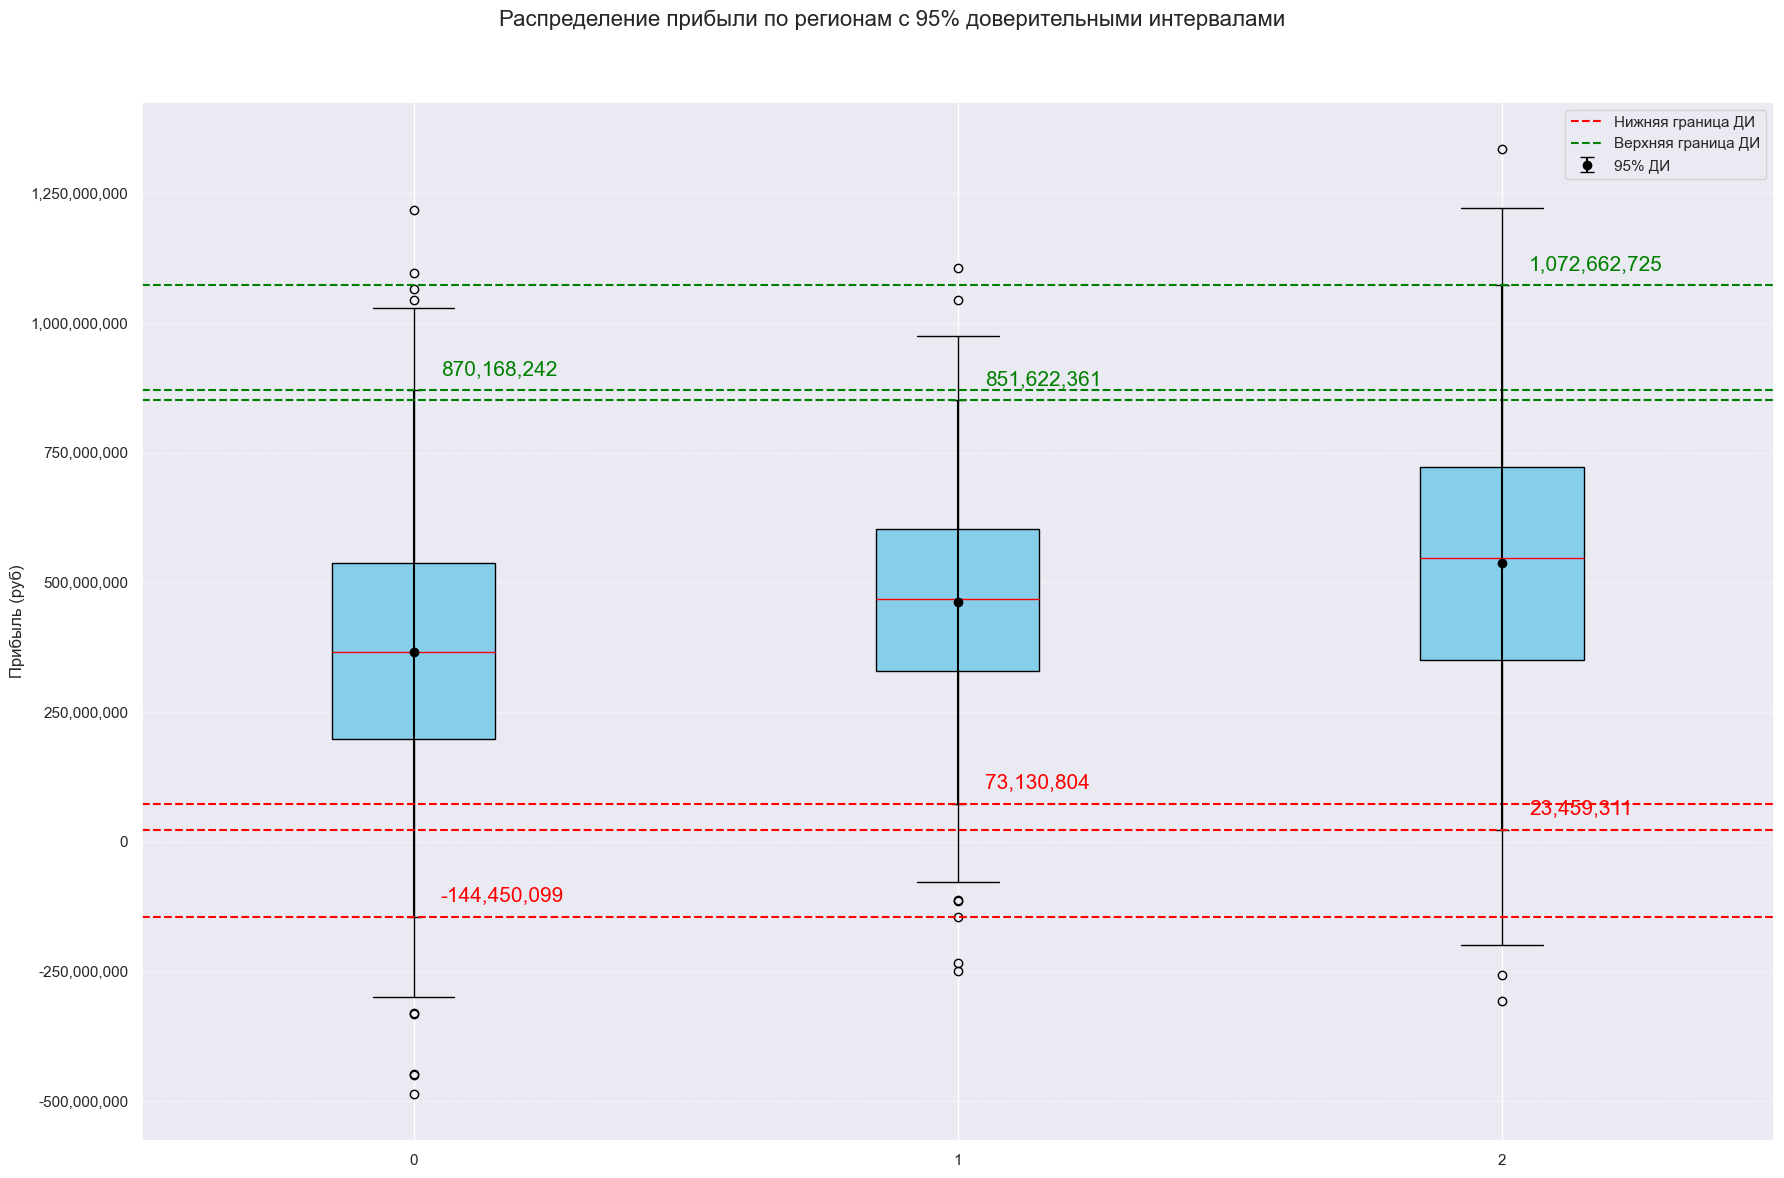

In [59]:
visualize_profits_on_one(profits_list, region_names)

## Выводы

На основе проведенного анализа можно сделать следующие выводы:  

Ключевые показатели по регионам:  
'Регион 0:'  
'- Средняя прибыль: 365,479,577.00 руб.'  
'- 95% доверительный интервал: [-144,450,099.00, 870,168,242.00] руб.'  
'- Риск убытков: 7.9%'  
'- Количество убытков: 79, Всего: 1000'  
'------'  
'Регион 1:'  
'- Средняя прибыль: 462,298,055.00 руб.'  
'- 95% доверительный интервал: [73,130,804.00, 851,622,361.00] руб.'  
'- Риск убытков: 1.1%'  
'- Количество убытков: 11, Всего: 1000'  
'------'  
'Регион 2:'  
'- Средняя прибыль: 537,441,516.00 руб.'  
'- 95% доверительный интервал: [23,459,311.00, 1,072,662,725.00] руб.'  
'- Риск убытков: 2.1%'  
'- Количество убытков: 21, Всего: 1000'  
'------'  

Рекомендация:  
Таким образом по риску у нас проходит два региона - 1 и 2  

Оптимальный выбор — Регион 1:  
Стабильность и корректность данных:  
Регион 1 демонстрирует наименьший риск убытков и минимальную сумму убытков, что указывает на надежность прогнозов.

Сравнение с Регионом 2:  
Регион 2 выглядит интереснее по верхней доверительной границе, но этот регион более рискованный + по нижнему порогу все таки уступает региону 1.  

Сравнение с Регионом 0:  
Регион 0 регион в принципе убыточен и его не стоит рассматривать.  

Итоговое решение:  
Рекомендуется к разработке Регион 1, так как он:  
Обеспечивает надежность данных и минимальный риск убытков.  
Предлагает стабильные прогнозы с корректными исходными данными.  

Это лучший вариант среди предоставленных.  

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Весь код выполняется без ошибок